# Due diligence: study and prepare the data

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
# import seaborn as sns  # to plot the heat maps
import numpy as np
import pandas as pd
from numpy.linalg import inv
from numpy import linalg as LA
from tqdm import trange, tqdm_notebook
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## Problem background and motivation
The problem at hand consists on mapping the *signals* (i.e. information) of illiquid assets to signals of liquid assets. The idea here is of course that one prefers to hold liquid assets over illiquid assets. The reason for this is actually more profund than just because you then have a tighter control on what you can do with your assets and when. For instance, one can easily see that when you are limited by liquidity, your initial investment cannot be as large as you wish, so if you want to invest a large sum you will have to dosify it during a long period of time. But then your total investment is not benefiting from the exponential growth from the start but progressively over a long period. Mathematically, for a total investment $I_0$ on a liquid asset with return $R$ over a time $t$ one has
$$
I_t^L = I_0 R^t = \frac{I_0}{n}(R^t + R^t + \cdots).
$$
However, for an illiquid asset one is forced to split this investment into $n$ chunks and one yields instead
$$
I_t^I = \frac{I_0}{n} R^t + \frac{I_0}{n} R^{t-1} + \cdots = \frac{I_0}{n}(R^t + R^{t-1}+ \cdots),
$$
which clearly makes it a worse investment!

 Thus, it would be great if we can predict, using available signals from illiquid assets, signals of liquid assets. One simple example of this might be predicting how a (liquid) real state fund will behave based on the information available on the housing market (which is more illiquid). In this way you dont need to get into the difficult position of owning (and managing) houses and instead you invest on the liquid shares of real states funds whose value will correlate with the housing market you studied.

## Problem statement
As explained above, we are looking for a map $f:\text{iliquid}\rightarrow \text{liquid}$. So what do we exactly have? Well we have information on $M$ liquid assets, which we want to predict, and $N$ iliquid assets, which will be used to predict. In particular, we have two different type of quantities for each liquid and illiquid asset at our disposal: the daily return and a unique set of industry group identifiers which tells us roughly in which sector each asset is. Mathematically we have:
<center>

|               | Liquid | Illiquid |
| :------------ | :------: | :----: |
| Returns        |   $\{ Y_j^t \in \mathbb{R} \} \text{ for } t\in \{t_1, \cdots, t_T\} \text{ and } j \in \{1,\cdots,M\}$   |  $\{ X_j^t \in \mathbb{R}\} \text{ for }  t\in \{t_1, \cdots, t_T\} \text{ and } j \in \{1,\cdots,N\}$ |
| Industry group        |   $\{ A_n^j \in \mathbb{Z^+}\} \text{ for } j \in \{1,\cdots,M\} \text{ and } n \in \{1,\cdots,4\} $   |   $\{ B_n^j \in \mathbb{Z^+} \} \text{ for } j \in \{1,\cdots, N\}  \text{ and } n \in \{1,\cdots,4\} $ |
</center>

where note that neither $A^j_n$ nor $B^j_n$  depend on the time $t$.

There is just one small catch: we are told that

> the dates are randomized and anonymized so there is no continuity or link between any dates.

 Thus, there is not much point in making $Y$ depend on $t$ so instead, we are going to treat each different day as an independent observation of the same random process for the purposes of training. In fact, the days inside the test data are not even present in the training data. So a priori, we propose the following map
$$ 
Y_j = f(X_1,\cdots,X_N; A^j_1,\cdots,A^j_4, B_1^1,B^1_2,\cdots,B^2_1,\cdots,B_N^4 ),  \text{ for each }  j\in \{1,\cdots,M\} 
$$

where this expression is understood to be implicitly evaluated for the same $t$. 

Note that we are here assumming that knowing what $A^j_n$'s the other $Y_{k\neq j}$ have shouldnt influence on how $Y_j$ is correlated with the iliquid data. Whether or not this assumption is entirely correct might be beyond the question as, at least a priori, it might be a source of overfitting.

So where do we start? Which model do we choose? Let's first have a look at the data. 

## Loading the data & first observations
Let's have a look at what we have:

In [4]:
# import data
X_train = pd.read_csv('X_train.csv')
X_supp = pd.read_csv('supplementary_data.csv')
Y_train = pd.read_csv('Y_train.csv')

X_test = pd.read_csv('X_test.csv')

X_train

,ID,ID_DAY,RET_216,RET_238,RET_45,RET_295,RET_230,RET_120,RET_188,RET_260,...,RET_122,RET_194,RET_72,RET_293,RET_281,RET_193,RET_95,RET_162,RET_297,ID_TARGET
0,0,3316,0.004024,0.009237,0.004967,NaN,0.017040,0.013885,0.041885,0.015207,...,0.007596,0.015010,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,139
1,1,3316,0.004024,0.009237,0.004967,NaN,0.017040,0.013885,0.041885,0.015207,...,0.007596,0.015010,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,129
2,2,3316,0.004024,0.009237,0.004967,NaN,0.017040,0.013885,0.041885,0.015207,...,0.007596,0.015010,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,136
3,3,3316,0.004024,0.009237,0.004967,NaN,0.017040,0.013885,0.041885,0.015207,...,0.007596,0.015010,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,161
4,4,3316,0.004024,0.009237,0.004967,NaN,0.017040,0.013885,0.041885,0.015207,...,0.007596,0.015010,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267095,267095,3028,0.025293,-0.003277,-0.028823,-0.006021,-0.008381,0.006805,0.018665,-0.010479,...,0.013698,-0.007358,0.022241,0.008688,0.006896,0.005854,-0.003103,-0.022325,0.014949,241
267096,267096,3028,0.025293,-0.003277,-0.028823,-0.006021,-0.008381,0.006805,0.018665,-0.010479,...,0.013698,-0.007358,0.022241,0.008688,0.006896,0.005854,-0.003103,-0.022325,0.014949,214
267097,267097,3028,0.025293,-0.003277,-0.028823,-0.006021,-0.008381,0.006805,0.018665,-0.010479,...,0.013698,-0.007358,0.022241,0.008688,0.006896,0.005854,-0.003103,-0.022325,0.014949,102
267098,267098,3028,0.025293,-0.003277,-0.028823,-0.006021,-0.008381,0.006805,0.018665,-0.010479,...,0.013698,-0.007358,0.022241,0.008688,0.006896,0.005854,-0.003103,-0.022325,0.014949,145


In [3]:
Y_train

,ID,RET_TARGET
0,0,-0.022351
1,1,-0.011892
2,2,-0.015285
3,3,-0.019226
4,4,0.006644
...,...,...
267095,267095,0.002080
267096,267096,-0.002565
267097,267097,-0.018406
267098,267098,0.045101


In [16]:
X_test

,ID,ID_DAY,RET_216,RET_238,RET_45,RET_295,RET_230,RET_120,RET_188,RET_260,...,RET_122,RET_194,RET_72,RET_293,RET_281,RET_193,RET_95,RET_162,RET_297,ID_TARGET
0,267100,83,0.043712,0.020260,0.027425,NaN,0.006963,0.000528,0.027680,0.037824,...,0.016991,0.022084,-0.006699,0.017606,0.005505,-0.000410,0.018637,0.020723,0.018418,139
1,267101,83,0.043712,0.020260,0.027425,NaN,0.006963,0.000528,0.027680,0.037824,...,0.016991,0.022084,-0.006699,0.017606,0.005505,-0.000410,0.018637,0.020723,0.018418,129
2,267102,83,0.043712,0.020260,0.027425,NaN,0.006963,0.000528,0.027680,0.037824,...,0.016991,0.022084,-0.006699,0.017606,0.005505,-0.000410,0.018637,0.020723,0.018418,136
3,267103,83,0.043712,0.020260,0.027425,NaN,0.006963,0.000528,0.027680,0.037824,...,0.016991,0.022084,-0.006699,0.017606,0.005505,-0.000410,0.018637,0.020723,0.018418,161
4,267104,83,0.043712,0.020260,0.027425,NaN,0.006963,0.000528,0.027680,0.037824,...,0.016991,0.022084,-0.006699,0.017606,0.005505,-0.000410,0.018637,0.020723,0.018418,217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114463,381563,415,-0.018322,0.034389,0.044101,-0.033431,-0.026487,-0.012058,0.041611,0.003381,...,-0.005801,-0.011807,-0.022010,-0.010799,-0.023107,-0.002279,-0.015246,-0.016463,-0.000903,241
114464,381564,415,-0.018322,0.034389,0.044101,-0.033431,-0.026487,-0.012058,0.041611,0.003381,...,-0.005801,-0.011807,-0.022010,-0.010799,-0.023107,-0.002279,-0.015246,-0.016463,-0.000903,214
114465,381565,415,-0.018322,0.034389,0.044101,-0.033431,-0.026487,-0.012058,0.041611,0.003381,...,-0.005801,-0.011807,-0.022010,-0.010799,-0.023107,-0.002279,-0.015246,-0.016463,-0.000903,102
114466,381566,415,-0.018322,0.034389,0.044101,-0.033431,-0.026487,-0.012058,0.041611,0.003381,...,-0.005801,-0.011807,-0.022010,-0.010799,-0.023107,-0.002279,-0.015246,-0.016463,-0.000903,145


In [4]:
X_supp

,ID_asset,CLASS_LEVEL_1,CLASS_LEVEL_2,CLASS_LEVEL_3,CLASS_LEVEL_4
0,216,2,2,12,20
1,238,2,2,12,21
2,45,3,5,20,32
3,295,10,22,49,77
4,230,4,10,28,47
...,...,...,...,...,...
195,241,3,8,26,42
196,214,2,2,13,22
197,102,1,1,5,12
198,145,2,2,12,20


Note this data, as is, looks like it can definetely be a source of problems if we dont handle the different scales among the different `CLASS_LEVEL_n`s. Indeed observe that they have wildly different distributions.

In [6]:
X_supp.drop(columns=["ID_asset"]).describe()

,CLASS_LEVEL_1,CLASS_LEVEL_2,CLASS_LEVEL_3,CLASS_LEVEL_4
count,200.000000,200.000000,200.000000,200.000000
mean,4.300000,9.280000,24.680000,39.620000
std,3.162278,7.858139,16.276431,24.468123
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,10.000000,17.000000
50%,3.000000,8.000000,24.500000,38.500000
75%,7.000000,17.000000,40.000000,61.000000
max,10.000000,22.000000,49.000000,77.000000


This is important because, as we teased, we will want to weight the iliquid returns `RET_n`s with their own `CLASS_LEVEL_` and the target's. We will describe this feature engenieering in more detail later on, but for now take my word that we need to standarise the industry classes:

In [5]:
X_supp[['CLASS_LEVEL_1', 'CLASS_LEVEL_2',"CLASS_LEVEL_3","CLASS_LEVEL_4"]] = StandardScaler().fit_transform(X_supp[['CLASS_LEVEL_1', 'CLASS_LEVEL_2',"CLASS_LEVEL_3","CLASS_LEVEL_4"]])
rows_norm = np.reshape( LA.norm(X_supp.drop(columns=["ID_asset"]).to_numpy(),axis=1),(200,1))

X_supp

,ID_asset,CLASS_LEVEL_1,CLASS_LEVEL_2,CLASS_LEVEL_3,CLASS_LEVEL_4
0,216,-0.729149,-0.928753,-0.780995,-0.803872
1,238,-0.729149,-0.928753,-0.780995,-0.762900
2,45,-0.412128,-0.546025,-0.288254,-0.312207
3,295,1.807021,1.622766,1.497935,1.531536
4,230,-0.095106,0.091855,0.204488,0.302374
...,...,...,...,...,...
195,241,-0.412128,-0.163297,0.081302,0.097514
196,214,-0.729149,-0.928753,-0.719403,-0.721928
197,102,-1.046170,-1.056329,-1.212144,-1.131648
198,145,-0.729149,-0.928753,-0.780995,-0.803872


Let's now look at `X_train` and `Y_train` again. It is clear that the data needs some resorting: note that most rows are repeated since the `RET_n` columns have the same value for the same day. This is because the data has been structured so that each row connects to one particular `ID_TARGET` but this doesnt add any information other than knowing whether or not there is data missing so let's reorganise this in the next section. 

First observe we have data fo $2748$ days which is, a prior, too little data for certain ML algorithms like deep neural networks. However, we will see later on that we can remedy this.

In [17]:
# number of days for which we have data
n_days = len(X_train["ID_DAY"].unique())
n_days

2748

Furthermore, as we discussed in the problem statement section, note that in the `X_test` data we have values of `ID_DAY` with data not in `X_train`:

In [18]:
# ID_DAY = 415  is in X_test but not in X_train
415 in X_train["ID_DAY"].unique()

False

So we need to be careful with how we treat `ID_DAY`. So far, aside of to separate the different observations of all the `RET_n` it should not play any significant predictive role. 

# Cleaning and reorganising the data
### Model considerations
Armed with the lessons learned above, let's begin by reorganising the data. How do we want the data to be organised? Obviously we want the train data to contain all necessary information but how that information is arranged depends a bit on what model we will use. 

Given the problem and the scarcity of data, it is hard not to start with a linear model of some sort. Thus we could propose 
$$
\hat{Y}_j = \sum_k X_k \beta^k_j + \sum_{lk} B_k^l \alpha_{lj}^k + \sum_k A_k^j \gamma_j^k + m_j, 
$$
where we again implicitly assume $Y_j$ and $X_k$ are at the same time $t$ and matrices $B_k^l$ and $A_k^j$ store all the asset coefficients. One could reasonably argue that in fact only the difference between $B$ and $A$ are important as this difference tells you how relevant one particular $X_k$ given how similar is for a given $Y_j$. We propose that models like 
$$
\hat{Y}_j = \sum_{kn} \frac{X_k}{1 + (B_n^k-A_n^j)^2} \beta^{kn}_j + m_j, 
$$
are very reasonable and deserve full attention. Think about it, if $B_n^k\approx A_n^j$ then $X_k$ is left untouch, however if $B_n^k\neq A_n^j$ then $X_k$ is suppressed by their difference squared (the $1$ just avoids $1/0$).  While the above expression is mathematically sound, it is a bit cumbersome to deal with since we are dealing with higher rank tensors for no good reason. We are essentially doing feature engineering so we can instead redefine what the features are by defining a new vector of features for each target $Y_j$
$$
\vec{F_j} = \left(1,\frac{X_1}{1+(B_1^1-A_1^j)^2},\frac{X_1}{1+(B_2^1-A_2^j)^2},\cdots, \frac{X_2}{1+(B_1^2-A_1^j)^2}, \cdots,\frac{X_N}{1+(B_4^N-A_4^j)^2} \right), \quad \text{where} \quad  \vec{F_j} \in \mathbb{R}^P
$$
so that
$$
\hat{Y}_j = \vec{F_j} \cdot \vec{\beta_j}, \quad \text{where} \quad \vec{\beta_j}[0]=m_j.
$$
Now this model is manifestly of the form of the linear models we are used to deal with. From now on, I will drop index $j$ as it is clear that with this model nor the loss nor the predicted $Y_j$ depend on anything with $k\neq j$.  Now if we use a mean squared error as our loss function then we already know that
$$
\mathcal{L} = \frac{1}{2S} \sum_\alpha^S (Y^\alpha - \hat{Y}^\alpha)^2 \equiv \frac{1}{2S} \sum_\alpha^S (Y^\alpha -  \vec{F}^\alpha \cdot \vec{\beta})^2 \quad \text{ then } \quad \partial_{\beta_j}\mathcal{L} = 0 \implies \vec{\beta} = (F^T F)^{-1} F^T \vec{y},
$$
where again here $\vec{\beta}$ is the entries of what we denoted above $\vec{\beta_j}$ for some particular $j$ and $F\in \mathbb{R}^{S\times P}$ is the matrix with $S$ rows (one for each observation) an $P$ columns (one for each flattened feature, c.f. definition of  $\vec{F_j}$ above).

Before moving on I feel like there is one last technical detail worth commenting. We weighted the returns above so that assets that are different are suppressed. But, what makes two different assets far away? Well, at first glance we assumed that two assets are different if their $A$'s and $B$'s are different or in other words we essentially assumed
$$
\textrm{dist}(R_j,R_k) = \sum_n (A_n^j-B^k_n)^2,
$$
but maybe there are some $A_n^j$'s that contribute more in distinguishing assets, so shouldnt we find out a set of $\beta_m$'s to weight the above euclidian distance
$$
\textrm{dist}(R_j,R_k) = \sum_n \beta_n (A_n^j-B^k_n)^2,
$$
what about other distance functions? Well first of all, the answer is we have implicitly already fitted those $\beta_m$'s. The reason behind why we have split each return into $4$ different weighted returns is to allow each to have its own coefficient (from the linear regression for instance). In this way, the learning algorithm will have these independent pieces of information to play with. Having said that, there are indeed alternative ways we could think of to estimate these $\beta_m$'s, for instance by cooking some loss function that demands two assets that behave similarly over all available observations to be close in some precise sense. However, we will not persue this direction now and rather focus on the bigger picture.

### Reshaping the data
As argued, it is clear that the input data to predict the $j$ -th asset should  contain all the iliquid returns `RET_n` weighted with all the iliquid class coefficients `B_n_k` and the $j$ th liquid asset class coefficients `A_n_j`. So we will stack it like
$$
X_{train} = 
\begin{bmatrix}
    F[1]_j^{t=1} &  F[2]_j^{t=1} & \cdots  &  F[P]_j^{t=1} \\
     F[1]_j^{t=2} &  F[2]_j^{t=2} & \cdots  &  F[P]_j^{t=2} \\
    \vdots & \vdots & \vdots & \vdots \\
    F[1]_j^{t=S} &  F[2]_j^{t=S} & \cdots  &  F[P]_j^{t=S} 
\end{bmatrix} \quad  \text{ and } \quad
Y_{train} = \begin{bmatrix}
    Y_j^{t=1} \\
    Y_j^{t=2} \\
    \vdots \\
    Y_j^{t=S} \\
\end{bmatrix}.
$$
where each row is an individual (day) observation. 

By looking at the data, we see we need to train $100$ individual linear models, one for each liquid asset as explained above. Let's extract the train data for one particular liquid asset from the total data and take it from there.

We begin by dropping the data on the rest of the liquid assets. 

In [377]:
# we picked asset 139 as an example
X_train_139 = X_train.loc[X_train['ID_TARGET'] == 139]
X_train_139

,ID,ID_DAY,RET_216,RET_238,RET_45,RET_295,RET_230,RET_120,RET_188,RET_260,...,RET_122,RET_194,RET_72,RET_293,RET_281,RET_193,RET_95,RET_162,RET_297,ID_TARGET
0,0,3316,0.004024,0.009237,0.004967,NaN,0.017040,0.013885,0.041885,0.015207,...,0.007596,0.015010,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,139
100,100,3355,0.025848,-0.002109,-0.021802,0.040229,0.015093,-0.015498,0.011188,0.011622,...,0.001506,0.003077,-0.002341,0.061228,0.005301,0.008942,-0.010232,0.005529,0.006545,139
200,200,1662,-0.012267,0.007461,0.051311,0.105340,-0.006361,0.004964,0.011933,0.018921,...,0.009226,0.032670,-0.000716,0.008429,-0.002871,0.009932,0.023721,0.009349,0.033554,139
300,300,3405,-0.033598,-0.003446,-0.009100,0.016753,-0.016952,-0.008924,-0.010984,0.001948,...,0.001551,-0.008077,0.009507,-0.008005,-0.016593,-0.007481,-0.024835,0.004360,0.031087,139
400,400,1602,0.029170,-0.084293,0.000325,0.021458,-0.018345,-0.012230,-0.001818,0.000842,...,-0.012181,0.002507,0.004408,-0.022913,-0.010133,-0.006468,-0.025205,-0.001612,-0.056735,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266605,266605,3332,-0.012034,-0.021459,-0.004453,-0.011604,0.086227,-0.003680,-0.022954,-0.011491,...,-0.005921,-0.000173,0.016216,-0.010907,-0.043811,-0.003677,0.003975,-0.004490,-0.005928,139
266704,266704,2314,0.001643,0.018795,0.052567,0.003184,0.102134,-0.001182,0.030033,0.010007,...,0.002858,0.006811,0.026210,-0.001437,0.011124,-0.000478,-0.013254,0.043495,0.002780,139
266803,266803,1863,0.010200,-0.003231,-0.018298,-0.009153,-0.055494,-0.001865,-0.035667,-0.020259,...,-0.003975,-0.006258,0.001214,-0.003871,-0.010329,-0.001843,0.009359,-0.017191,-0.012770,139
266902,266902,2868,0.000532,-0.006588,-0.053379,-0.011904,-0.068993,-0.018487,0.003643,-0.012991,...,0.005227,0.002653,-0.045902,-0.008034,-0.016351,-0.001056,-0.018058,-0.012541,-0.001299,139


Filling the `NaN`'s with their columns average (which is the most resonable fix I can think of at this stage)

In [378]:
X_train_139 = X_train_139.fillna(X_train_139.mean())
X_train_139

,ID,ID_DAY,RET_216,RET_238,RET_45,RET_295,RET_230,RET_120,RET_188,RET_260,...,RET_122,RET_194,RET_72,RET_293,RET_281,RET_193,RET_95,RET_162,RET_297,ID_TARGET
0,0,3316,0.004024,0.009237,0.004967,0.000729,0.017040,0.013885,0.041885,0.015207,...,0.007596,0.015010,0.014733,-0.000476,0.006539,-0.010233,0.001251,-0.003102,-0.094847,139
100,100,3355,0.025848,-0.002109,-0.021802,0.040229,0.015093,-0.015498,0.011188,0.011622,...,0.001506,0.003077,-0.002341,0.061228,0.005301,0.008942,-0.010232,0.005529,0.006545,139
200,200,1662,-0.012267,0.007461,0.051311,0.105340,-0.006361,0.004964,0.011933,0.018921,...,0.009226,0.032670,-0.000716,0.008429,-0.002871,0.009932,0.023721,0.009349,0.033554,139
300,300,3405,-0.033598,-0.003446,-0.009100,0.016753,-0.016952,-0.008924,-0.010984,0.001948,...,0.001551,-0.008077,0.009507,-0.008005,-0.016593,-0.007481,-0.024835,0.004360,0.031087,139
400,400,1602,0.029170,-0.084293,0.000325,0.021458,-0.018345,-0.012230,-0.001818,0.000842,...,-0.012181,0.002507,0.004408,-0.022913,-0.010133,-0.006468,-0.025205,-0.001612,-0.056735,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266605,266605,3332,-0.012034,-0.021459,-0.004453,-0.011604,0.086227,-0.003680,-0.022954,-0.011491,...,-0.005921,-0.000173,0.016216,-0.010907,-0.043811,-0.003677,0.003975,-0.004490,-0.005928,139
266704,266704,2314,0.001643,0.018795,0.052567,0.003184,0.102134,-0.001182,0.030033,0.010007,...,0.002858,0.006811,0.026210,-0.001437,0.011124,-0.000478,-0.013254,0.043495,0.002780,139
266803,266803,1863,0.010200,-0.003231,-0.018298,-0.009153,-0.055494,-0.001865,-0.035667,-0.020259,...,-0.003975,-0.006258,0.001214,-0.003871,-0.010329,-0.001843,0.009359,-0.017191,-0.012770,139
266902,266902,2868,0.000532,-0.006588,-0.053379,-0.011904,-0.068993,-0.018487,0.003643,-0.012991,...,0.005227,0.002653,-0.045902,-0.008034,-0.016351,-0.001056,-0.018058,-0.012541,-0.001299,139


And now we need to weight the iliquid returns with the industry class information as discussed. For that we will use the already loaded `X_supp` data and define the following helper function which does that plus all the above steps:

In [6]:
def weight_returns(x_df : pd.DataFrame, supp_df : pd.DataFrame, liquid_ID : int)->pd.DataFrame:
    """
    Transforms the illiquid returns in `x_df` dataframe by weighting them with the class information in `supp_df` of all illiquid assets and liquid asset with ID `liquid_ID`. Note this means this only applies for the data points associated with the liquid asset with ID liquid_ID. This transformation is given by
    ```
    RET_n(1+(B^n_1-A^j_1)**2),   RET_n(1+(B^n_2-A^j_2)**2), ...
    ```
    Note how this enlarges the number of features by a factor of 4.

    ### Parameters
    - x_df : pd.DataFrame
    - supp_df : pd.DataFrame
    - liquid_ID : int

    ### Returns
    - weighted_df : pd.DataFrame
    """
    # filter for liquid_ID
    train_df = x_df.loc[x_df['ID_TARGET'] == liquid_ID] 
    # handle NaNs
    train_df = train_df.fillna(train_df.mean())
    
    # get all return names
    cols_names = train_df.columns
    ret_names = []
    for name in cols_names:
        if "RET_" in name:
            ret_names.append(name)

    # 4D numpy vector of liquid classes
    liquid_classes = supp_df.loc[supp_df['ID_asset'] == liquid_ID].drop(columns=["ID_asset"]).to_numpy()[0]

    # weight the data
    temp_df = pd.DataFrame({"ID":train_df["ID"]})
    for ret_name in ret_names: # plus all the other data
        for j in range(4):
            col_name =  ret_name + "_" + str(j)
            iliquid_classes = supp_df.loc[supp_df['ID_asset'] == int(ret_name[4:])].drop(columns=["ID_asset"]).to_numpy()[0]
            
            temp_df[col_name] =  train_df[ret_name].to_numpy() / (1 + (iliquid_classes[j] - liquid_classes[j])**2)
    return temp_df


Let's test it with liquid target id `139`:

In [7]:
weight_returns(X_train,X_supp,139)

,ID,RET_216_0,RET_216_1,RET_216_2,RET_216_3,RET_238_0,RET_238_1,RET_238_2,RET_238_3,RET_45_0,...,RET_95_2,RET_95_3,RET_162_0,RET_162_1,RET_162_2,RET_162_3,RET_297_0,RET_297_1,RET_297_2,RET_297_3
0,0,0.002870,0.003778,0.002758,0.002506,0.006588,0.008672,0.006331,0.005526,0.002608,...,0.000133,0.000129,-0.001189,-0.001181,-0.000824,-0.000705,-0.020538,-0.022636,-0.018484,-0.016595
100,100,0.018436,0.024268,0.017716,0.016094,-0.001504,-0.001980,-0.001446,-0.001262,-0.011448,...,-0.001091,-0.001055,0.002120,0.002104,0.001468,0.001257,0.001417,0.001562,0.001275,0.001145
200,200,-0.008749,-0.011517,-0.008407,-0.007638,0.005322,0.007005,0.005114,0.004464,0.026942,...,0.002529,0.002445,0.003585,0.003558,0.002483,0.002125,0.007266,0.008008,0.006539,0.005871
300,300,-0.023964,-0.031545,-0.023028,-0.020920,-0.002458,-0.003235,-0.002362,-0.002062,-0.004778,...,-0.002648,-0.002560,0.001672,0.001660,0.001158,0.000991,0.006732,0.007419,0.006058,0.005439
400,400,0.020806,0.027387,0.019992,0.018163,-0.060123,-0.079141,-0.057773,-0.050430,0.000171,...,-0.002687,-0.002598,-0.000618,-0.000614,-0.000428,-0.000366,-0.012285,-0.013541,-0.011057,-0.009927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266605,266605,-0.008584,-0.011299,-0.008248,-0.007493,-0.015306,-0.020148,-0.014708,-0.012839,-0.002338,...,0.000424,0.000410,-0.001722,-0.001709,-0.001192,-0.001021,-0.001284,-0.001415,-0.001155,-0.001037
266704,266704,0.001172,0.001543,0.001126,0.001023,0.013406,0.017647,0.012882,0.011245,0.027601,...,-0.001413,-0.001366,0.016677,0.016553,0.011551,0.009887,0.000602,0.000663,0.000542,0.000486
266803,266803,0.007275,0.009577,0.006991,0.006351,-0.002305,-0.003034,-0.002215,-0.001933,-0.009608,...,0.000998,0.000965,-0.006591,-0.006543,-0.004565,-0.003908,-0.002765,-0.003048,-0.002489,-0.002234
266902,266902,0.000379,0.000499,0.000364,0.000331,-0.004699,-0.006185,-0.004515,-0.003941,-0.028027,...,-0.001925,-0.001861,-0.004809,-0.004773,-0.003330,-0.002851,-0.000281,-0.000310,-0.000253,-0.000227


Sanity check: the first entry should be `RET_216/(1+(B^216_1-A^139_1)**2)` which is indeed $0.004024/(1+(-0.729149-(-1.363192))^2)\approx 0.00287016$. Now for the training `Y_train` we simply do 

In [381]:
# get relevant IDs
ID_list = weight_returns(X_train,X_supp,139)["ID"]
# select those relevant IDs 
Y_train.loc[Y_train['ID'].isin(ID_list)]

,ID,RET_TARGET
0,0,-0.022351
100,100,0.008354
200,200,0.012218
300,300,-0.004456
400,400,0.008788
...,...,...
266605,266605,0.019691
266704,266704,0.001614
266803,266803,0.003476
266902,266902,-0.002670


which is clearly doing what we want. So we can convine these two methods in one single handy function:

In [8]:
def data_to_train(x_df : pd.DataFrame, y_df : pd.DataFrame, supp_df : pd.DataFrame,liquid_ID : int) -> tuple:
    """
    Transforms the illiquid returns in `x_df` using `weight_returns(x_df,supp_df,liquid_ID)` and reformats `y_df` to match this appropiately.

    ### Parameters
    - x_df : pd.DataFrame
    - y_df : pd.DataFrame
    - supp_df : pd.DataFrame
    - liquid_ID : int

    ### Returns
    - (x_array, y_array) : tuple of numpy arrays
    """
    # get weighted data using `weight_returns` function
    train_x_df = weight_returns(x_df,supp_df,liquid_ID)

    # select relevant liquid returns
    ID_list = train_x_df["ID"]
    train_y_df = y_df.loc[y_df['ID'].isin(ID_list)]    

    # drop IDs (useless for training now) and convert to np array
    train_x_array = train_x_df.drop(columns=["ID"]).to_numpy()
    train_y_array = train_y_df.drop(columns=["ID"]).to_numpy()
    return train_x_array, train_y_array

In [383]:
data_to_train(X_train,Y_train,X_supp,139)

(array([[ 0.00287013,  0.003778  ,  0.00275796, ..., -0.02263632,
         -0.01848395, -0.01659465],
        [ 0.01843633,  0.02426802,  0.01771579, ...,  0.00156197,
          0.00127544,  0.00114507],
        [-0.00874932, -0.01151685, -0.00840737, ...,  0.00800812,
          0.00653912,  0.00587074],
        ...,
        [ 0.00727536,  0.00957666,  0.00699102, ..., -0.00304767,
         -0.00248861, -0.00223424],
        [ 0.00037916,  0.00049909,  0.00036434, ..., -0.00030993,
         -0.00025307, -0.00022721],
        [ 0.01804019,  0.02374656,  0.01733513, ...,  0.00356788,
          0.00291339,  0.00261561]]),
 array([[-0.02235101],
        [ 0.00835403],
        [ 0.01221795],
        ...,
        [ 0.00347641],
        [-0.00266971],
        [-0.01650764]]))

which manifestly reproduces the above reformatting. 

# Training the model
### A brief comment on $\textrm{det} (F^TF)$

With the data now properly aranged we are in a position to begin training the model. There is one last observation in order, as we will shortly see, the determinant of $F^TF$ is incredibly small. We will solve this problem with a straightforward PCA treatment.

Recal that the solution of the linear problem is given by $\vec{\beta} = (F^T F)^{-1} F^T \vec{y}$, we thus have

In [384]:
temp_X, temp_Y = data_to_train(X_train,Y_train,X_supp,139)

temp_beta = inv( temp_X.T @ temp_X ) @ temp_X.T @ temp_Y
temp_beta

array([[ 6.68470264e+17],
       [ 9.82986828e+17],
       [-1.49521256e+18],
       [-6.02096000e+17],
       [ 4.23236079e+17],
       [-7.14196390e+17],
       [ 9.37105682e+16],
       [ 5.08860702e+17],
       [-3.53284248e+18],
       [ 1.71838954e+18],
       [-3.04631065e+18],
       [ 5.01531393e+18],
       [-4.02172257e+18],
       [-3.44549990e+18],
       [-8.63744300e+17],
       [ 8.99278511e+18],
       [-1.39737730e+18],
       [ 2.06897889e+18],
       [ 5.05524213e+17],
       [-1.75652345e+18],
       [-6.18413075e+17],
       [-7.05988700e+17],
       [ 2.27813785e+18],
       [-3.16616555e+17],
       [-1.03539086e+19],
       [ 2.39410039e+19],
       [-6.97625259e+18],
       [-1.11632354e+19],
       [ 3.48105866e+17],
       [-9.06585469e+17],
       [ 5.68642423e+17],
       [ 3.42309491e+17],
       [ 1.27806341e+19],
       [ 5.95186984e+18],
       [-2.91807923e+18],
       [-1.55688621e+19],
       [-2.17399436e+18],
       [-4.29173244e+18],
       [ 8.1

which is remarkable that it managed to invert it but is for all purposes and effects a singular matrix. And indeed we see that a large part of the spectrum is tiny:

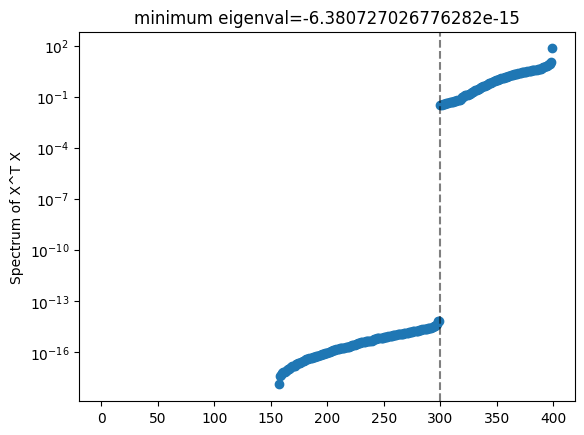

In [385]:
lambs, _ =  LA.eigh(temp_X.T @ temp_X )
plt.scatter(range(len(lambs)),lambs)
plt.ylabel("Spectrum of X^T X")
plt.title("minimum eigenval="+str(min(lambs)))
plt.axvline([300],ls="--",c="black",alpha=0.5)
plt.yscale("log")
plt.show()

What an interesting feature this gap in the spectrum. With that cutoff at around $100$ eigenvalues (vertical line) this is screaming for PCA! 

In [386]:
pca = PCA(n_components=0.99) # explain 99% of variability
pca.fit( temp_X.T @ temp_X )
print(pca.explained_variance_ratio_)
print(len(pca.explained_variance_ratio_))

[0.6890955  0.04495872 0.02910278 0.02493956 0.02048768 0.01867304
 0.01510933 0.01301305 0.01149781 0.01015708 0.00824222 0.00783082
 0.00764701 0.00687102 0.00598082 0.00593555 0.00544787 0.00523669
 0.00496757 0.00456368 0.00435993 0.00426588 0.0040271  0.00365229
 0.00356204 0.00323537 0.00312497 0.00289106 0.00277724 0.00250244
 0.00244335 0.00212096 0.00199401 0.00189756 0.0017849  0.00158884
 0.00147037 0.0013594  0.00119562]
39


With just `39` components we explained $+99\%$ of the data! We inspect the first principal component to see what we can learn.

Text(0.5, 0, 'features')

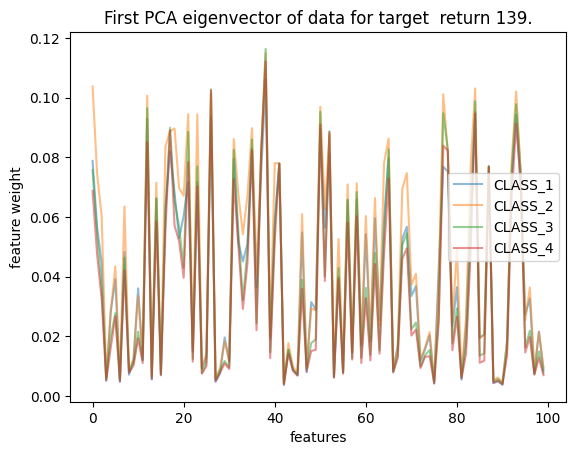

In [387]:
plt.plot(range(100),pca.components_[0][0:-3:4],alpha=0.5,label="CLASS_1")
plt.plot(range(100),pca.components_[0][1:-2:4],alpha=0.5,label="CLASS_2")
plt.plot(range(100),pca.components_[0][2:-1:4],alpha=0.5,label="CLASS_3")
plt.plot(range(100),pca.components_[0][3::4],alpha=0.5,label="CLASS_4")
plt.legend(loc="right")
plt.title("First PCA eigenvector of data for target  return 139.")
plt.ylabel("feature weight")
plt.xlabel("features")

First off, there seems to be no warning signs. We can also observe that weighted returns from `CLASS_2` tend to account for more variability than the rest . This makes sense, observe that it's the class closest to its average (which is $0$) so one expects on average it's weighted return to be less suppressed. This is a direct consequence our model choice which deserves some caution.

In [388]:
X_supp[X_supp["ID_asset"] == 139]

,ID_asset,CLASS_LEVEL_1,CLASS_LEVEL_2,CLASS_LEVEL_3,CLASS_LEVEL_4
100,139,-1.363192,-1.183905,-1.458515,-1.582341


With that out of the way, let's project the data to a smaller subspace using PCA before we train our model

In [94]:
pca = PCA(n_components=0.99) # explain 99% of variability
pca.fit( temp_X.T @ temp_X )
X_temp_PCA = pca.transform(temp_X)
temp_beta = inv( X_temp_PCA.T @ X_temp_PCA ) @ X_temp_PCA.T @ temp_Y
temp_beta.shape

(39, 1)

### Training the model

The strategy is to apply PCA to the data, train it and test it individually for each target liquid return.

PCA + train/test split:

In [389]:
# again we pick 139 as our example asset.
X_train_139, Y_train_139 = data_to_train(X_train,Y_train,X_supp,139)

pca = PCA(n_components=0.999) # explain 99.9% of variability
pca.fit( X_train_139 )
X_train_139_PCA = pca.transform(X_train_139)

x_train, x_test, y_train, y_test = train_test_split(X_train_139_PCA, Y_train_139, test_size=0.25)

Fit:

In [390]:
# note this wont have an intercept term
beta_139 = inv( x_train.T @ x_train ) @ x_train.T @ y_train
beta_139.shape

(94, 1)

And the test is done using our proposed $\hat{Y}_j = \vec{F_j} \cdot \vec{\beta_j}$

In [391]:
y_pred = x_test @ beta_139
y_true = y_test

We will be evaluated on some custom metric so let's use it to evaluate our model:

In [19]:
def custom_loss(y_true,y_pred):
    sign_sum = 0.5 * np.abs( np.sign(y_true) + np.sign(y_pred) )
    sum_array = np.multiply( np.abs(y_true), sign_sum ) 
    sum_term = np.sum( sum_array )
    norm_term = np.sum( np.abs(y_true) )
    return np.divide( sum_term,norm_term ) 

In [393]:
custom_loss(y_true,y_pred) # test accu

0.5274801914990961

In [394]:
y_pred = x_train @ beta_139
y_true = y_train
custom_loss(y_true,y_pred) # train accu


0.6369733706515371

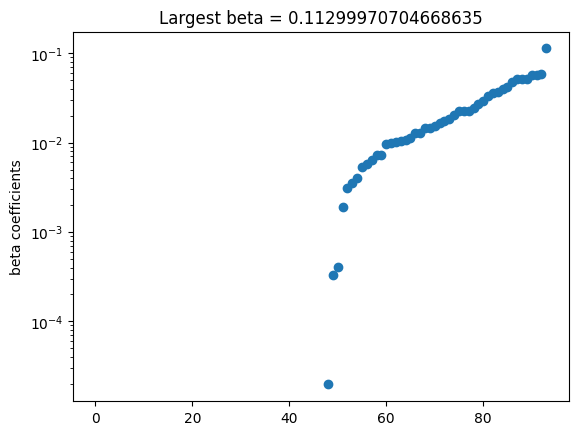

In [114]:
plt.scatter(range(len(beta_139)),sorted(beta_139))
plt.yscale("log")
plt.ylabel("beta coefficients")
plt.title("Largest beta = " + str(max(beta_139)[0]))
plt.show()

These coefficients seem small enough but they can get quite large when we use a large number of principal components which might mean we need to include some form of regularisation in the future (turns out it doesnt seem to help). To address this issue, we are now going to proceed to do a more systematic model analysis. 

## Linear model analysis

It seems like with the particular model above we can get around $60\%$ test accurancy which is not too bad but not too great either. However, before we start drawing any conclusion let's squeeze this model all we can and see what we can learn. For this, we are going to wrap the above model in a single function and we are going to study the effect of tweeking the hyperparameters (number of principal components and test/train split) in detail. So here's what this function looks like:

In [18]:
from sklearn.linear_model import Ridge

def custom_loss_no_norm(y_true,y_pred):
    sign_sum = 0.5 * np.abs( np.sign(y_true) + np.sign(y_pred) )
    sum_array = np.multiply( np.abs(y_true), sign_sum ) 
    sum_term = np.sum( sum_array )
    return sum_term 

def inneficient_linear_model_stats(X_train,Y_train,X_supp,test_percent,PCA_percent=0.99):
    ID_target_list = X_train["ID_TARGET"].unique()
    
    mse_tot_train,mse_tot_test = 0,0
    test_loss_no_norm, test_norm1_term = 0,0
    train_loss_no_norm, train_norm1_term = 0,0
    for target in ID_target_list:
        X_train_target, Y_train_target = data_to_train(X_train,Y_train,X_supp,target)
        
        pca = PCA(n_components=PCA_percent) # explain % of variability
        pca.fit( X_train_target.T @ X_train_target )
        X_train_target_PCA = pca.transform(X_train_target)

        # add y_intercept
        X_train_target_PCA = np.hstack((X_train_target_PCA, np.ones((1,X_train_target_PCA.shape[0])).T))

        x_train, x_test, y_train, y_test = train_test_split(X_train_target_PCA, Y_train_target, test_size=test_percent)

        # no regu
        beta = inv( x_train.T @ x_train ) @ x_train.T @ y_train

        y_pred = x_test @ beta
        y_true = y_test
        mse_tot_test += mean_squared_error(y_true, y_pred)
        test_loss_no_norm += custom_loss_no_norm(y_true,y_pred)
        test_norm1_term += np.sum( np.abs(y_true))

        y_pred = x_train @ beta
        y_true = y_train
        mse_tot_train += mean_squared_error(y_true, y_pred)
        train_loss_no_norm += custom_loss_no_norm(y_true,y_pred)
        train_norm1_term += np.sum( np.abs(y_true))

    test_accu = test_loss_no_norm/test_norm1_term
    train_accu = train_loss_no_norm/train_norm1_term
    return test_accu, train_accu, mse_tot_test/len(ID_target_list), mse_tot_train/len(ID_target_list)

In [396]:
inneficient_linear_model_stats(X_train,Y_train,X_supp,0.2,PCA_percent=0.99)

(0.7277615125100152,
 0.7557121087730975,
 0.0003785509114923225,
 0.00035816587913660344)

Now that's much better! If we are going to fine tune this model we are going to need a more efficient way of doing so. Note that every time we call `inneficient_linear_model_stats(X_train,Y_train,X_supp,test_percent,PCA_percen)` we compute the PCA of the data which amounts at doing $100$ SVDs. But if all we want to be choosing is the number of principal components used this is unecessary! Let's instead define a function that returns all the PCA objects so that we can use them later on:

In [10]:
def data_PCA(X_train,Y_train,X_supp):
    ID_target_list = X_train["ID_TARGET"].unique()

    PCA_ls = []
    for target in ID_target_list:
        X_train_target, Y_train_target = data_to_train(X_train,Y_train,X_supp,target)
        
        pca = PCA(n_components=1) # compute all of them
        PCA_ls.append( PCA().fit( X_train_target.T @ X_train_target ) ) 

    return PCA_ls

def linear_model_stats(PCA_ls,X_train,Y_train,X_supp,test_percent,PCA_n):
    ID_target_list = X_train["ID_TARGET"].unique()
    
    mse_tot_train,mse_tot_test = 0,0
    test_loss_no_norm, test_norm1_term = 0,0
    train_loss_no_norm, train_norm1_term = 0,0
    for (j,target) in enumerate(ID_target_list):
        X_train_target, Y_train_target = data_to_train(X_train,Y_train,X_supp,target)

        pca_trnsf = PCA_ls[j].components_[0:PCA_n+1,:]

        X_train_target_PCA =  X_train_target @ pca_trnsf.T

        # add y_intercept
        X_train_target_PCA = np.hstack((X_train_target_PCA, np.ones((1,X_train_target_PCA.shape[0])).T))

        x_train, x_test, y_train, y_test = train_test_split(X_train_target_PCA, Y_train_target, test_size=test_percent)

        # no regu
        beta = inv( x_train.T @ x_train ) @ x_train.T @ y_train

        y_pred = x_test @ beta
        y_true = y_test
        mse_tot_test += mean_squared_error(y_true, y_pred)
        test_loss_no_norm += custom_loss_no_norm(y_true,y_pred)
        test_norm1_term += np.sum( np.abs(y_true))

        y_pred = x_train @ beta
        y_true = y_train
        mse_tot_train += mean_squared_error(y_true, y_pred)
        train_loss_no_norm += custom_loss_no_norm(y_true,y_pred)
        train_norm1_term += np.sum( np.abs(y_true))

    test_accu = test_loss_no_norm/test_norm1_term
    train_accu = train_loss_no_norm/train_norm1_term
    return test_accu, train_accu, mse_tot_test/len(ID_target_list), mse_tot_train/len(ID_target_list)

So now we have the lengthy `data_PCA(X_train,Y_train,X_supp)`:

In [11]:
model_PCAs =  data_PCA(X_train,Y_train,X_supp)

But the now faster `linear_model_stats(model_PCAs,X_train,Y_train,X_supp,0.2,PCA_percent=40)` !

In [12]:
linear_model_stats(model_PCAs,X_train,Y_train,X_supp,0.2,40)

(0.735298083045162,
 0.7520840961606847,
 0.0003844688635659014,
 0.00035881801183205384)

which is 4 times faster. It is reasonable then to see what happens as we increase the principal components from $1$ to $250$ since this is simply $250\times 20s = 5000s \approx 1h30min$. Let's queue this one up and go for a walk:

In [142]:
test_perc = 0.2
mse_tot_test_ls = []
mse_tot_train_ls = []
test_accu_ls = []
train_accu_ls = []
n_pca_comp_ls = list(range(1,250,1))
for n_pca_comp in n_pca_comp_ls:
    test_accu, train_accu, mse_tot_test, mse_tot_train = linear_model_stats(model_PCAs,X_train,Y_train,X_supp,test_perc,n_pca_comp)
    test_accu_ls.append(test_accu)
    train_accu_ls.append(train_accu)

    mse_tot_test_ls.append(mse_tot_test)
    mse_tot_train_ls.append(mse_tot_train)
    print(n_pca_comp/250, test_accu, train_accu)


0.004 0.7208255103579642 0.7193600494555855
0.008 0.7236801193556139 0.7256581645973439
0.012 0.7223729465188438 0.7289006124556503
0.016 0.7249914945746675 0.7306881795497859
0.02 0.7294278104839595 0.7316079053039165
0.024 0.7275907785254038 0.7332385490640225
0.028 0.72703314028112 0.7348883575941791
0.032 0.7304303363399841 0.7359917164112894
0.036 0.7320990125170005 0.7359969908394512
0.04 0.7328677170767652 0.7367650133284498
0.044 0.7307109060994792 0.7374221919770276
0.048 0.7310325205020813 0.7384176954205878
0.052 0.727519628510892 0.7406805897351012
0.056 0.7334157115346731 0.7402938815252886
0.06 0.7327638082806126 0.7408700037376675
0.064 0.729532641704095 0.7421874999001835
0.068 0.7358082695144895 0.742265161906248
0.072 0.729989975724733 0.7442443819443513
0.076 0.7372189241080809 0.7424138499001434
0.08 0.7353439356662913 0.7442192254136121
0.084 0.7334665535574886 0.7449972570508908
0.088 0.733755519918496 0.7473792557830208
0.092 0.735302550952468 0.7469578822168789


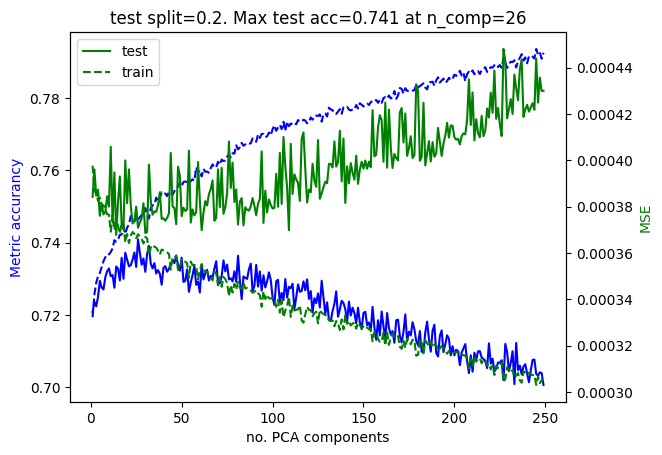

In [143]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(n_pca_comp_ls,test_accu_ls, label="test",c="blue")
ax1.plot(n_pca_comp_ls,train_accu_ls, label="train",ls="dashed",c="blue")
ax1.set_ylabel('Metric accurancy',c="blue")

ax2.plot(n_pca_comp_ls,mse_tot_test_ls, label="test",c="green")
ax2.plot(n_pca_comp_ls,mse_tot_train_ls, label="train",ls="dashed",c="green")
ax2.set_ylabel('MSE',c="green")

ax1.set_xlabel("no. PCA components")
plt.title("test split="+str(test_perc)+". Max test acc="+str(round(max(test_accu_ls),4))+" at n_comp="+str(n_pca_comp_ls[test_accu_ls.index(max(test_accu_ls))]))
plt.legend()
plt.show()

Now we are talking! Let's see what's the effect of adjusting the test set size too, but lets limit the no. of pca components to $150$.

In [146]:
percent_ls = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
n_pca_comp_ls = list(range(1,150,1))
# mse_tot_test_ls_ls = []
# mse_tot_train_ls_ls = []
# test_accu_ls_ls = []
# train_accu_ls_ls = []
for percent in percent_ls:
    test_perc = percent
    mse_tot_test_ls = []
    mse_tot_train_ls = []
    test_accu_ls = []
    train_accu_ls = []
    for n_pca_comp in n_pca_comp_ls:
        test_accu, train_accu, mse_tot_test, mse_tot_train = linear_model_stats(model_PCAs,X_train,Y_train,X_supp,test_perc,n_pca_comp)
        test_accu_ls.append(test_accu)
        train_accu_ls.append(train_accu)
        mse_tot_test_ls.append(mse_tot_test)
        mse_tot_train_ls.append(mse_tot_train)
        # print(n_pca_comp/250, test_accu)

    test_accu_ls_ls.append(test_accu_ls)
    train_accu_ls_ls.append(train_accu_ls)
    mse_tot_test_ls_ls.append(mse_tot_test_ls)
    mse_tot_train_ls_ls.append(mse_tot_train_ls)
    print(percent/len(percent_ls))

0.008333333333333333
0.016666666666666666
0.024999999999999998
0.03333333333333333
0.041666666666666664
0.049999999999999996


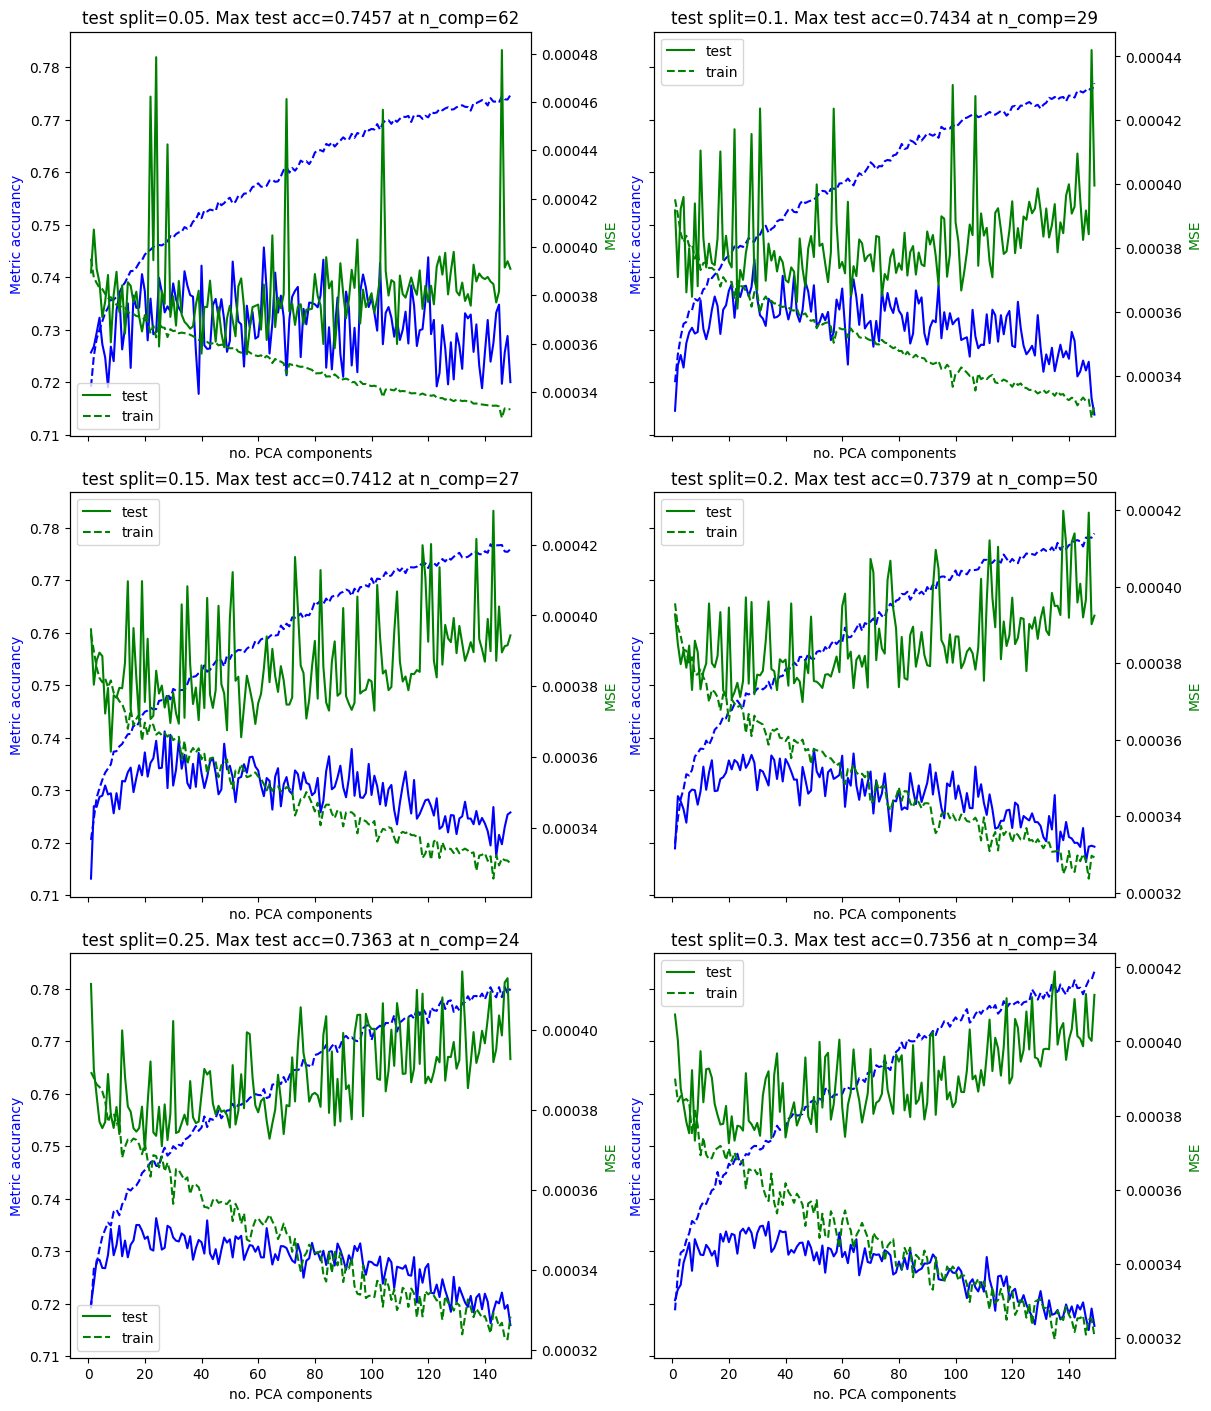

In [148]:

fig, axs = plt.subplots(3, 2, figsize=(12, 14), layout='constrained',sharex=True,sharey=True)
i=0
for ax in axs.flat:
    test_perc = percent_ls[i]
    mse_tot_test_ls = mse_tot_test_ls_ls[i]
    mse_tot_train_ls = mse_tot_train_ls_ls[i]
    test_accu_ls = test_accu_ls_ls[i]
    train_accu_ls = train_accu_ls_ls[i]
    i += 1

    ax_twin = ax.twinx()

    ax.plot(n_pca_comp_ls,test_accu_ls, label="test",c="blue")
    ax.plot(n_pca_comp_ls,train_accu_ls, label="train",ls="dashed",c="blue")
    ax.set_ylabel('Metric accurancy',c="blue")

    ax_twin.plot(n_pca_comp_ls,mse_tot_test_ls, label="test",c="green")
    ax_twin.plot(n_pca_comp_ls,mse_tot_train_ls, label="train",ls="dashed",c="green")
    ax_twin.set_ylabel('MSE',c="green")

    ax.set_xlabel("no. PCA components")
    plt.title("test split="+str(test_perc)+". Max test acc="+str(round(max(test_accu_ls),4))+" at n_comp="+str(n_pca_comp_ls[test_accu_ls.index(max(test_accu_ls))]))
    plt.legend()

plt.show()

This is looking promising! We can smooth out that noise by, given one test/train split percentage, taking averages over different splits of the data. In physics this would be called disorder average and in machine learning is apparently called cross validation. Let's see if we can tune the model further! We estimate the time of the following simulation to be $20s/(realisation\times component) \times 100 realisations \times 55 components = 110000s \approx 30h$! That's too long, let's optimise our `linear_model_stats` function further, it looks like loading the data over and over is unecesary and expensive, let's address this:

In [13]:
def data_to_train_pd(X_train,Y_train,supp_df,liquid_ID):
    train_df = weight_returns(X_train,supp_df,liquid_ID)
    ID_list = train_df["ID"]
    test_df = Y_train.loc[Y_train['ID'].isin(ID_list)]    
    
    train_array = train_df.drop(columns=["ID"])
    test_array = test_df.drop(columns=["ID"])
    train_array["ID_TARGET"] = liquid_ID
    test_array["ID_TARGET"] = liquid_ID
    return train_array, test_array



df_x_train = pd.DataFrame()
df_y_train = pd.DataFrame()
for target_ID in X_train["ID_TARGET"].unique():
     df_temp_x, df_temp_y = data_to_train_pd(X_train,Y_train,X_supp,target_ID)
     df_x_train = pd.concat([df_x_train,df_temp_x])
     df_y_train = pd.concat([df_y_train,df_temp_y])
     
df_x_train[df_x_train["ID_TARGET"] == 139]

,RET_216_0,RET_216_1,RET_216_2,RET_216_3,RET_238_0,RET_238_1,RET_238_2,RET_238_3,RET_45_0,RET_45_1,...,RET_95_3,RET_162_0,RET_162_1,RET_162_2,RET_162_3,RET_297_0,RET_297_1,RET_297_2,RET_297_3,ID_TARGET
0,0.002870,0.003778,0.002758,0.002506,0.006588,0.008672,0.006331,0.005526,0.002608,0.003530,...,0.000129,-0.001189,-0.001181,-0.000824,-0.000705,-0.020538,-0.022636,-0.018484,-0.016595,139
100,0.018436,0.024268,0.017716,0.016094,-0.001504,-0.001980,-0.001446,-0.001262,-0.011448,-0.015497,...,-0.001055,0.002120,0.002104,0.001468,0.001257,0.001417,0.001562,0.001275,0.001145,139
200,-0.008749,-0.011517,-0.008407,-0.007638,0.005322,0.007005,0.005114,0.004464,0.026942,0.036471,...,0.002445,0.003585,0.003558,0.002483,0.002125,0.007266,0.008008,0.006539,0.005871,139
300,-0.023964,-0.031545,-0.023028,-0.020920,-0.002458,-0.003235,-0.002362,-0.002062,-0.004778,-0.006468,...,-0.002560,0.001672,0.001660,0.001158,0.000991,0.006732,0.007419,0.006058,0.005439,139
400,0.020806,0.027387,0.019992,0.018163,-0.060123,-0.079141,-0.057773,-0.050430,0.000171,0.000231,...,-0.002598,-0.000618,-0.000614,-0.000428,-0.000366,-0.012285,-0.013541,-0.011057,-0.009927,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266605,-0.008584,-0.011299,-0.008248,-0.007493,-0.015306,-0.020148,-0.014708,-0.012839,-0.002338,-0.003165,...,0.000410,-0.001722,-0.001709,-0.001192,-0.001021,-0.001284,-0.001415,-0.001155,-0.001037,139
266704,0.001172,0.001543,0.001126,0.001023,0.013406,0.017647,0.012882,0.011245,0.027601,0.037364,...,-0.001366,0.016677,0.016553,0.011551,0.009887,0.000602,0.000663,0.000542,0.000486,139
266803,0.007275,0.009577,0.006991,0.006351,-0.002305,-0.003034,-0.002215,-0.001933,-0.009608,-0.013006,...,0.000965,-0.006591,-0.006543,-0.004565,-0.003908,-0.002765,-0.003048,-0.002489,-0.002234,139
266902,0.000379,0.000499,0.000364,0.000331,-0.004699,-0.006185,-0.004515,-0.003941,-0.028027,-0.037941,...,-0.001861,-0.004809,-0.004773,-0.003330,-0.002851,-0.000281,-0.000310,-0.000253,-0.000227,139


In [14]:
def fast_linear_model_stats(PCA_ls,df_x_train,df_y_train,test_percent,PCA_n):
    ID_target_list = X_train["ID_TARGET"].unique()
    
    mse_tot_train,mse_tot_test = 0,0
    test_loss_no_norm, test_norm1_term = 0,0
    train_loss_no_norm, train_norm1_term = 0,0
    for (j,target) in enumerate(ID_target_list):
        X_train_target = df_x_train[df_x_train["ID_TARGET"] == target]
        Y_train_target = df_y_train[df_x_train["ID_TARGET"] == target]
        X_train_target = X_train_target.drop(columns=["ID_TARGET"]).to_numpy()
        Y_train_target = Y_train_target.drop(columns=["ID_TARGET"]).to_numpy()

        pca_trnsf = PCA_ls[j].components_[0:PCA_n+1,:]

        X_train_target_PCA =  X_train_target @ pca_trnsf.T

        # add y_intercept
        X_train_target_PCA = np.hstack((X_train_target_PCA, np.ones((1,X_train_target_PCA.shape[0])).T))

        x_train, x_test, y_train, y_test = train_test_split(X_train_target_PCA, Y_train_target, test_size=test_percent)

        # no regu
        beta = inv( x_train.T @ x_train ) @ x_train.T @ y_train

        y_pred = x_test @ beta
        y_true = y_test
        mse_tot_test += mean_squared_error(y_true, y_pred)
        test_loss_no_norm += custom_loss_no_norm(y_true,y_pred)
        test_norm1_term += np.sum( np.abs(y_true))

        y_pred = x_train @ beta
        y_true = y_train
        mse_tot_train += mean_squared_error(y_true, y_pred)
        train_loss_no_norm += custom_loss_no_norm(y_true,y_pred)
        train_norm1_term += np.sum( np.abs(y_true))

    test_accu = test_loss_no_norm/test_norm1_term
    train_accu = train_loss_no_norm/train_norm1_term
    return test_accu, train_accu, mse_tot_test/len(ID_target_list), mse_tot_train/len(ID_target_list)

In [15]:
fast_linear_model_stats(model_PCAs,df_x_train,df_y_train,0.1,40)

(0.7364792198225127,
 0.7515951760328441,
 0.00037698489795563673,
 0.00036115935031399786)

Which is almost a factor of $10$ faster! Now each realisation should be $\approx 2min$ so the entire thing should be around $\approx 3h$. Armed with this new tool we can head back to our cross-validation:

We plot the average of our data:

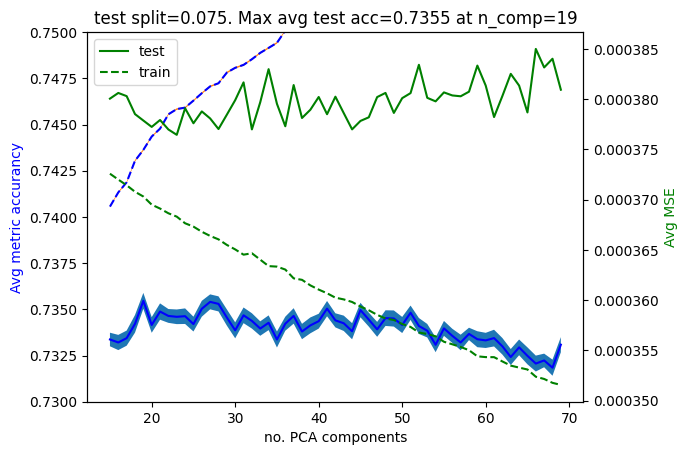

In [187]:
avg_test_mse = np.mean(test_mse_array,axis=1)
avg_train_mse = np.mean(train_mse_array,axis=1)
avg_test_accu = np.mean(test_accu_array,axis=1)
avg_train_accu = np.mean(train_accu_array,axis=1)

err_test_mse  = np.std(test_mse_array, axis=1) / np.sqrt(split_realisations)
err_train_mse  = np.std(train_mse_array, axis=1) / np.sqrt(split_realisations)
err_test_accu = np.std(test_accu_array, axis=1) / np.sqrt(split_realisations)
err_train_accu  = np.std(train_accu_array, axis=1) / np.sqrt(split_realisations)


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(n_pca_comp_ls,avg_test_accu, label="test",c="blue")
ax1.fill_between(n_pca_comp_ls, avg_test_accu-err_test_accu, avg_test_accu+err_test_accu)

ax1.plot(n_pca_comp_ls,avg_train_accu, label="train",ls="dashed",c="blue")
ax1.fill_between(n_pca_comp_ls, avg_train_accu-err_train_accu, avg_train_accu+err_train_accu)

ax1.set_ylim(0.73,0.75)

ax1.set_ylabel('Avg metric accurancy',c="blue")

ax2.plot(n_pca_comp_ls,avg_test_mse, label="test",c="green")
ax1.fill_between(n_pca_comp_ls, avg_test_mse-err_test_mse, avg_test_mse+err_test_mse)

ax2.plot(n_pca_comp_ls,avg_train_mse, label="train",ls="dashed",c="green")
ax1.fill_between(n_pca_comp_ls, avg_train_mse-err_train_mse, avg_train_mse+err_train_mse)

ax2.set_ylabel('Avg MSE',c="green")

ax1.set_xlabel("no. PCA components")
plt.title("test split="+str(test_perc)+". Max avg test acc="+str(round(max(avg_test_accu),4))+" at n_comp="+str(n_pca_comp_ls[list(avg_test_accu).index(max(avg_test_accu))]))
plt.legend()
plt.show()

Perhaps too small of a test set? Let's see $0.15$? Also, we probably dont need to average over $100$ realisations, look like it converges fast enough.

In [188]:
test_perc = 0.15

split_realisations = 50
n_pca_comp_ls = list(range(15,70,1))

# test_mse_array = np.zeros((len(n_pca_comp_ls), split_realisations))
# train_mse_array = np.zeros((len(n_pca_comp_ls), split_realisations))
# test_accu_array = np.zeros((len(n_pca_comp_ls), split_realisations))
# train_accu_array = np.zeros((len(n_pca_comp_ls), split_realisations))

for j in range(split_realisations):
    for (k,n_pca_comp) in enumerate(n_pca_comp_ls):
        test_accu, train_accu, mse_tot_test, mse_tot_train = fast_linear_model_stats(model_PCAs,df_x_train,df_y_train,X_supp,test_perc,n_pca_comp)
        test_mse_array[k,j] = mse_tot_test
        train_mse_array[k,j] = mse_tot_train
        test_accu_array[k,j] = test_accu
        train_accu_array[k,j] = train_accu

    print(j/split_realisations)

0.0
0.02
0.04
0.06
0.08
0.1
0.12
0.14
0.16
0.18
0.2
0.22
0.24
0.26
0.28
0.3
0.32
0.34
0.36
0.38
0.4
0.42
0.44
0.46
0.48
0.5
0.52
0.54
0.56
0.58
0.6
0.62
0.64
0.66
0.68
0.7
0.72
0.74
0.76
0.78
0.8
0.82
0.84
0.86
0.88
0.9
0.92
0.94
0.96
0.98


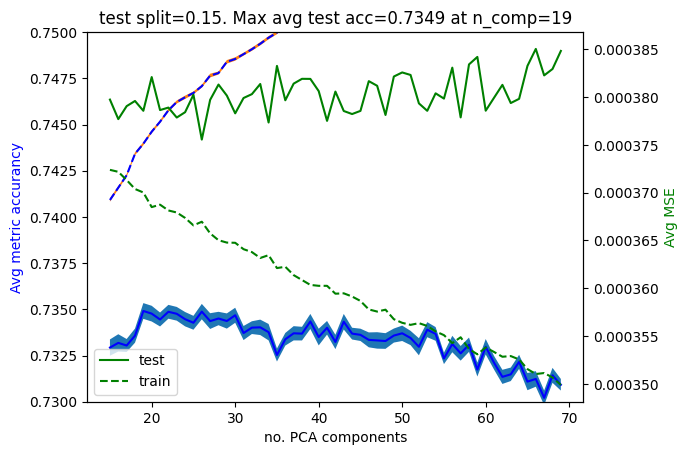

In [189]:
avg_test_mse = np.mean(test_mse_array,axis=1)
avg_train_mse = np.mean(train_mse_array,axis=1)
avg_test_accu = np.mean(test_accu_array,axis=1)
avg_train_accu = np.mean(train_accu_array,axis=1)

err_test_mse  = np.std(test_mse_array, axis=1) / np.sqrt(split_realisations)
err_train_mse  = np.std(train_mse_array, axis=1) / np.sqrt(split_realisations)
err_test_accu = np.std(test_accu_array, axis=1) / np.sqrt(split_realisations)
err_train_accu  = np.std(train_accu_array, axis=1) / np.sqrt(split_realisations)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(n_pca_comp_ls,avg_test_accu, label="test",c="blue")
ax1.fill_between(n_pca_comp_ls, avg_test_accu-err_test_accu, avg_test_accu+err_test_accu)

ax1.plot(n_pca_comp_ls,avg_train_accu, label="train",ls="dashed",c="blue")
ax1.fill_between(n_pca_comp_ls, avg_train_accu-err_train_accu, avg_train_accu+err_train_accu)

ax1.set_ylim(0.73,0.75)

ax1.set_ylabel('Avg metric accurancy',c="blue")

ax2.plot(n_pca_comp_ls,avg_test_mse, label="test",c="green")
ax1.fill_between(n_pca_comp_ls, avg_test_mse-err_test_mse, avg_test_mse+err_test_mse)

ax2.plot(n_pca_comp_ls,avg_train_mse, label="train",ls="dashed",c="green")
ax1.fill_between(n_pca_comp_ls, avg_train_mse-err_train_mse, avg_train_mse+err_train_mse)

ax2.set_ylabel('Avg MSE',c="green")

ax1.set_xlabel("no. PCA components")
plt.title("test split="+str(test_perc)+". Max avg test acc="+str(round(max(avg_test_accu),4))+" at n_comp="+str(n_pca_comp_ls[list(avg_test_accu).index(max(avg_test_accu))]))
plt.legend()
plt.show()

`n_comp=19` it is!. It's clear at this stage that this model is capable of potentially reaching accurancies close to $75\%$. Naturally, the more train data we have, the larger the test accurancy. At this stage, all we can hope for is to choose a particular number of PCA components based on the above considerations and hope for the best. For the data challenge, we could grind the best accurancy out by trying all reasonable no. of components but this is not the best use of my time. Hence I will stop tunning the linear model here. It is also worth commenting that I did try out adding regularisation to the model but this didnt seem to help. Insead of diving into analysis what else I tried but didnt work better I have decided, in the sake of time, to focus the discussion on the model interpretation and its subsequent submission.

# Linear model interpretation and submission

## Submission

The beautiful thing about linear models is that is one of the few models in machine learning that offers simple ways of **actually** understanding the model decision making. To illustrate this, let's quickly see what we can learn from (by now our favourite) target return `RET_139`. For that we need to translate the above lessons into a predicting model. As mentioned, we will choose $19$ principal components for our PCA and train on the entire data on this (to see if we can squeeze a last drop). Let's construct that function and test it works with the train set

In [16]:
def data_to_test_pd(X_test,supp_df,liquid_ID):
    test_df = weight_returns(X_test,supp_df,liquid_ID)
    test_df["ID_TARGET"] = liquid_ID
    return test_df

df_x_test_train = pd.DataFrame()
for target_ID in X_train["ID_TARGET"].unique():
     df_temp_x = data_to_test_pd(X_train,X_supp,target_ID)
     df_x_test_train = pd.concat([df_x_test_train,df_temp_x])
     
df_x_test_train

,ID,RET_216_0,RET_216_1,RET_216_2,RET_216_3,RET_238_0,RET_238_1,RET_238_2,RET_238_3,RET_45_0,...,RET_95_3,RET_162_0,RET_162_1,RET_162_2,RET_162_3,RET_297_0,RET_297_1,RET_297_2,RET_297_3,ID_TARGET
0,0,0.002870,0.003778,0.002758,0.002506,0.006588,0.008672,0.006331,0.005526,0.002608,...,0.000129,-0.001189,-0.001181,-0.000824,-0.000705,-0.020538,-0.022636,-0.018484,-0.016595,139
100,100,0.018436,0.024268,0.017716,0.016094,-0.001504,-0.001980,-0.001446,-0.001262,-0.011448,...,-0.001055,0.002120,0.002104,0.001468,0.001257,0.001417,0.001562,0.001275,0.001145,139
200,200,-0.008749,-0.011517,-0.008407,-0.007638,0.005322,0.007005,0.005114,0.004464,0.026942,...,0.002445,0.003585,0.003558,0.002483,0.002125,0.007266,0.008008,0.006539,0.005871,139
300,300,-0.023964,-0.031545,-0.023028,-0.020920,-0.002458,-0.003235,-0.002362,-0.002062,-0.004778,...,-0.002560,0.001672,0.001660,0.001158,0.000991,0.006732,0.007419,0.006058,0.005439,139
400,400,0.020806,0.027387,0.019992,0.018163,-0.060123,-0.079141,-0.057773,-0.050430,0.000171,...,-0.002598,-0.000618,-0.000614,-0.000428,-0.000366,-0.012285,-0.013541,-0.011057,-0.009927,139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266703,266703,-0.012034,-0.012034,-0.010992,-0.011348,-0.021459,-0.021459,-0.019601,-0.019828,-0.004046,...,0.000581,-0.003203,-0.002199,-0.001680,-0.001651,-0.002273,-0.001773,-0.001574,-0.001608,155
266802,266802,0.001643,0.001643,0.001501,0.001549,0.018795,0.018795,0.017167,0.017367,0.047766,...,-0.001937,0.031023,0.021304,0.016272,0.015997,0.001066,0.000831,0.000738,0.000754,155
266901,266901,0.010200,0.010200,0.009317,0.009619,-0.003231,-0.003231,-0.002952,-0.002986,-0.016627,...,0.001368,-0.012262,-0.008420,-0.006431,-0.006322,-0.004896,-0.003819,-0.003391,-0.003464,155
267000,267000,0.000532,0.000532,0.000486,0.000501,-0.006588,-0.006588,-0.006017,-0.006087,-0.048504,...,-0.002639,-0.008945,-0.006143,-0.004692,-0.004612,-0.000498,-0.000388,-0.000345,-0.000352,155


In [20]:
def linear_model_predict(PCA_ls,df_x_test,df_x_train,df_y_train,supp_df,PCA_n=19):
    ID_target_list = df_x_test["ID_TARGET"].unique()

    prediction_df = pd.DataFrame()
    for (j,target) in enumerate(ID_target_list):
        X_train_target = df_x_train[df_x_train["ID_TARGET"] == target]
        X_train_target = X_train_target.drop(columns=["ID_TARGET"]).to_numpy()

        X_test_target = df_x_test[df_x_test["ID_TARGET"] == target]
        X_test_target = X_test_target.drop(columns=["ID_TARGET"])
        IDs = X_test_target["ID"]
        X_test_target = X_test_target.drop(columns=["ID"]).to_numpy()

        Y_train_target = df_y_train[df_x_train["ID_TARGET"] == target]
        Y_train_target = Y_train_target.drop(columns=["ID_TARGET"]).to_numpy()

        pca_trnsf = PCA_ls[j].components_[0:PCA_n+1,:]

        # transform train
        X_train_target_PCA =  X_train_target @ pca_trnsf.T
        # transform test
        X_test_target_PCA =  X_test_target @ pca_trnsf.T


        # add y_intercept train 
        X_train_target_PCA = np.hstack((X_train_target_PCA, np.ones((1,X_train_target_PCA.shape[0])).T))

        # add y_intercept test
        X_test_target_PCA = np.hstack((X_test_target_PCA, np.ones((1,X_test_target_PCA.shape[0])).T))

        # no regu
        beta = inv( X_train_target_PCA.T @ X_train_target_PCA ) @ X_train_target_PCA.T @ Y_train_target


        y_pred = X_test_target_PCA @ beta

        y_pred_df = pd.DataFrame()
        y_pred_df["ID"] = IDs
        y_pred_df["RET_TARGET"] = np.sign(y_pred)
        prediction_df = pd.concat([prediction_df,y_pred_df])
    
    return prediction_df.sort_values(by=['ID'],ignore_index=True)

predicted_df = linear_model_predict(model_PCAs,df_x_test_train,df_x_train,df_y_train,X_supp,PCA_n=19)

custom_loss(Y_train["RET_TARGET"],predicted_df["RET_TARGET"])

0.7436186405690427

Which does very well as it is in fact its own training accurancy. Now for the actual test set:

In [21]:
df_x_test = pd.DataFrame()
for target_ID in X_test["ID_TARGET"].unique():
     df_temp_x = data_to_test_pd(X_test,X_supp,target_ID)
     df_x_test = pd.concat([df_x_test,df_temp_x])

In [43]:
PCA_n = 21
predicted_df = linear_model_predict(model_PCAs,df_x_test,df_x_train,df_y_train,X_supp,PCA_n)
predicted_df

,ID,RET_TARGET
0,267100,1.0
1,267101,-1.0
2,267102,-1.0
3,267103,1.0
4,267104,1.0
...,...,...
114463,381563,-1.0
114464,381564,-1.0
114465,381565,-1.0
114466,381566,1.0


Let's save our prediction:

In [44]:
predicted_df.to_csv("./submission_PCA_" + str(PCA_n) + ".csv",index=False)

Alright, `PCA_n=19` did well, $\sim 73.9\% $. Let's try a few more to see if we can get in the $74\%$'s! Let's run a final overnight test to see if we can get a more educated guess than `PCA_n=19`:

In [226]:
test_perc = 0.01

split_realisations = 2000
n_pca_comp_ls = list(range(17,29,1))

test_mse_array = np.zeros((len(n_pca_comp_ls), split_realisations))
train_mse_array = np.zeros((len(n_pca_comp_ls), split_realisations))
test_accu_array = np.zeros((len(n_pca_comp_ls), split_realisations))
train_accu_array = np.zeros((len(n_pca_comp_ls), split_realisations))

for j in range(split_realisations):
    for (k,n_pca_comp) in enumerate(n_pca_comp_ls):
        test_accu, train_accu, mse_tot_test, mse_tot_train = fast_linear_model_stats(model_PCAs,df_x_train,df_y_train,X_supp,test_perc,n_pca_comp)
        test_mse_array[k,j] = mse_tot_test
        train_mse_array[k,j] = mse_tot_train
        test_accu_array[k,j] = test_accu
        train_accu_array[k,j] = train_accu

    print(j/split_realisations)

0.0
0.0005
0.001
0.0015
0.002
0.0025
0.003
0.0035
0.004
0.0045
0.005
0.0055
0.006
0.0065
0.007
0.0075
0.008
0.0085
0.009
0.0095
0.01
0.0105
0.011
0.0115
0.012
0.0125
0.013
0.0135
0.014
0.0145
0.015
0.0155
0.016
0.0165
0.017
0.0175
0.018
0.0185
0.019
0.0195
0.02
0.0205
0.021
0.0215
0.022
0.0225
0.023
0.0235
0.024
0.0245
0.025
0.0255
0.026
0.0265
0.027
0.0275
0.028
0.0285
0.029
0.0295
0.03
0.0305
0.031
0.0315
0.032
0.0325
0.033
0.0335
0.034
0.0345
0.035
0.0355
0.036
0.0365
0.037
0.0375
0.038
0.0385
0.039
0.0395
0.04
0.0405
0.041
0.0415
0.042
0.0425
0.043
0.0435
0.044
0.0445
0.045
0.0455
0.046
0.0465
0.047
0.0475
0.048
0.0485
0.049
0.0495
0.05
0.0505
0.051
0.0515
0.052
0.0525
0.053
0.0535
0.054
0.0545
0.055
0.0555
0.056
0.0565
0.057
0.0575
0.058
0.0585
0.059
0.0595
0.06
0.0605
0.061
0.0615
0.062
0.0625
0.063
0.0635
0.064
0.0645
0.065
0.0655
0.066
0.0665
0.067
0.0675
0.068
0.0685
0.069
0.0695
0.07
0.0705
0.071
0.0715
0.072
0.0725
0.073
0.0735
0.074
0.0745
0.075
0.0755
0.076
0.0765
0.077
0.

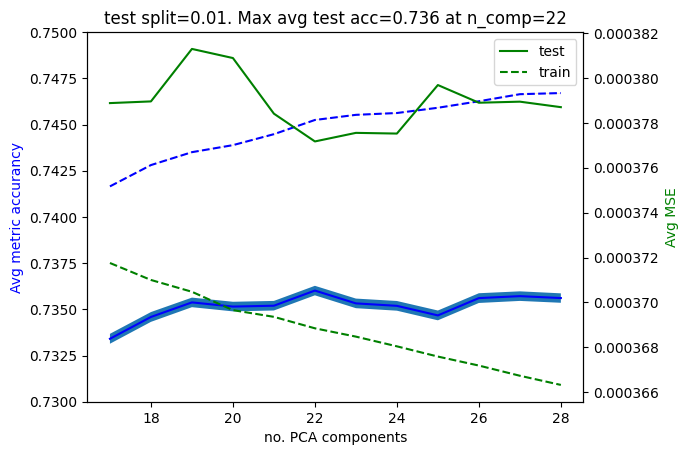

In [227]:
avg_test_mse = np.mean(test_mse_array,axis=1)
avg_train_mse = np.mean(train_mse_array,axis=1)
avg_test_accu = np.mean(test_accu_array,axis=1)
avg_train_accu = np.mean(train_accu_array,axis=1)

err_test_mse  = np.std(test_mse_array, axis=1) / np.sqrt(split_realisations)
err_train_mse  = np.std(train_mse_array, axis=1) / np.sqrt(split_realisations)
err_test_accu = np.std(test_accu_array, axis=1) / np.sqrt(split_realisations)
err_train_accu  = np.std(train_accu_array, axis=1) / np.sqrt(split_realisations)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(n_pca_comp_ls,avg_test_accu, label="test",c="blue")
ax1.fill_between(n_pca_comp_ls, avg_test_accu-err_test_accu, avg_test_accu+err_test_accu)

ax1.plot(n_pca_comp_ls,avg_train_accu, label="train",ls="dashed",c="blue")
ax1.fill_between(n_pca_comp_ls, avg_train_accu-err_train_accu, avg_train_accu+err_train_accu)

ax1.set_ylim(0.73,0.75)

ax1.set_ylabel('Avg metric accurancy',c="blue")

ax2.plot(n_pca_comp_ls,avg_test_mse, label="test",c="green")
ax1.fill_between(n_pca_comp_ls, avg_test_mse-err_test_mse, avg_test_mse+err_test_mse)

ax2.plot(n_pca_comp_ls,avg_train_mse, label="train",ls="dashed",c="green")
ax1.fill_between(n_pca_comp_ls, avg_train_mse-err_train_mse, avg_train_mse+err_train_mse)

ax2.set_ylabel('Avg MSE',c="green")

ax1.set_xlabel("no. PCA components")
plt.title("test split="+str(test_perc)+". Max avg test acc="+str(round(max(avg_test_accu),4))+" at n_comp="+str(n_pca_comp_ls[list(avg_test_accu).index(max(avg_test_accu))]))
plt.legend()
plt.show()

Okay, let's try then `PCA_n=22` and take it from there. Here's a plot with all my submissions:

Text(0.5, 0, 'pca_com')

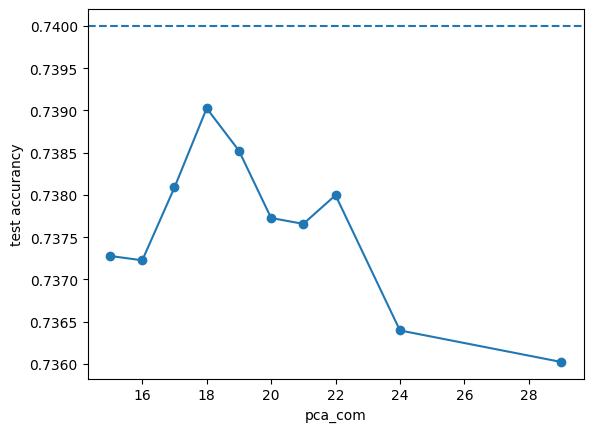

In [45]:
test_accus = [0.7372781509514295, 0.7372266203920959, 0.7380890945496226,0.7390256249523817,0.7385244220332879,0.7377275167466955, 0.7376576670402171, 0.7379971832389312,0.7363969993867265,0.7360243522354202]
pca_com = [15,16,17,18,19,20,21, 22,24,29]
plt.plot(pca_com,test_accus)
plt.scatter(pca_com,test_accus)
plt.axhline([0.74],ls="--")
# plt.ylim(0.735,0.745)
plt.ylabel("test accurancy")
plt.xlabel("pca_com")


might be worth trying `PCA_n < 19`, but we will leave it here. What a great challenge!



## Model analysis and interpretation

Before we put a stop to this challenge, let's take a moment to see what we can learn from our model. It is clear that in reality we hace $N$ independent linear models for each liquid return so it should sufices to study one particular liquid return, naturally: `RET_139`. Let's take a look at the $\beta$ coefficients of the model:

Text(0.5, 1.0, 'Intercept = -0.0008091638702157965')

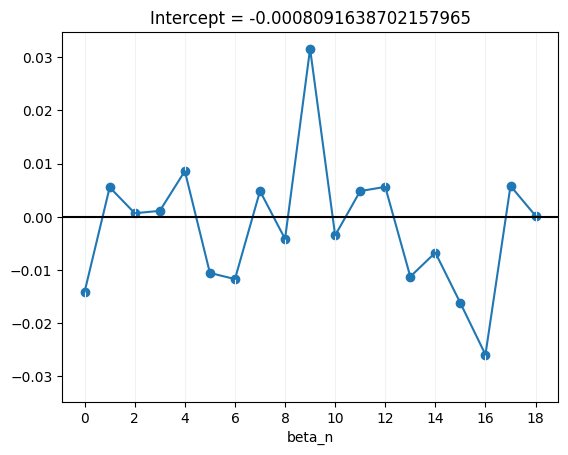

In [416]:
# again we pick 139 as our example asset.
X_train_139, Y_train_139 = data_to_train(X_train,Y_train,X_supp,139)

pca = PCA(n_components=19) # best test
pca.fit( X_train_139 )
X_train_139_PCA = pca.transform(X_train_139)

# add intercept 
X_train_139_PCA = np.hstack((X_train_139_PCA, np.ones((1,X_train_139_PCA.shape[0])).T))

# no regu
betas = inv( X_train_139_PCA.T @ X_train_139_PCA ) @ X_train_139_PCA.T @ Y_train_139

m, beta = betas[0], betas[1:]

plt.plot(beta)
plt.scatter(range(len(beta)),beta)
plt.axhline(y=0,c="black")
plt.xticks(range(0,len(beta),2))
plt.ylim(-max(beta)-max(beta)/10,max(beta)+max(beta)/10)
plt.xlabel("PCA component n")
plt.xlabel("beta_n")
plt.grid(axis='x', color='0.95')
plt.title("Intercept = "+str(m[0]))


Interestingly, the components that contribute the most to the prediction of the model are the 9th and the 16th components and there is very little intercept. (Note how the magnitude of the $\beta$'s is already within reason: this is why adding regularisation didnt seem to help.) Let's take a look at why this might be. Well, first off, the average returns of `RET_139` are

In [417]:
mean_ret = np.mean(Y_train_139)
print() # skip a line
mean_ret

0.00018195198700454712

which is indeed a number of the same order of magnitude as the intercept (albeit negative), so it is reasonable to think that this is compensating for this. Next, we have that the 9th and 16th components have weights like:

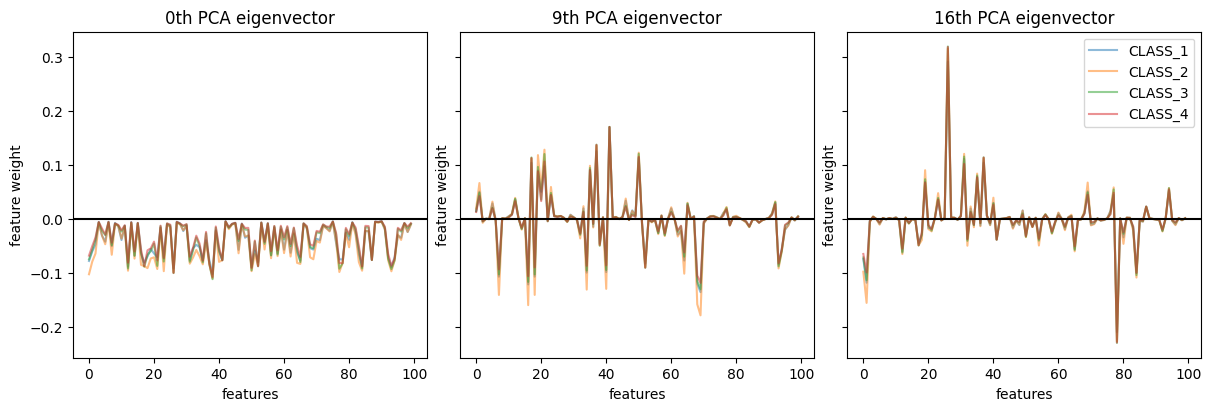

In [265]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), layout='constrained',sharex=True,sharey=True)

axs[0].plot(range(100),pca.components_[0][0:-3:4],alpha=0.5,label="CLASS_1")
axs[0].plot(range(100),pca.components_[0][1:-2:4],alpha=0.5,label="CLASS_2")
axs[0].plot(range(100),pca.components_[0][2:-1:4],alpha=0.5,label="CLASS_3")
axs[0].plot(range(100),pca.components_[0][3::4],alpha=0.5,label="CLASS_4")
axs[0].axhline(y=0,c="black")
axs[0].set_title("0th PCA eigenvector")
axs[0].set_ylabel("feature weight")
axs[0].set_xlabel("features")

axs[1].plot(range(100),pca.components_[9][0:-3:4],alpha=0.5,label="CLASS_1")
axs[1].plot(range(100),pca.components_[9][1:-2:4],alpha=0.5,label="CLASS_2")
axs[1].plot(range(100),pca.components_[9][2:-1:4],alpha=0.5,label="CLASS_3")
axs[1].plot(range(100),pca.components_[9][3::4],alpha=0.5,label="CLASS_4")
axs[1].axhline(y=0,c="black")
axs[1].set_title("9th PCA eigenvector")
axs[1].set_ylabel("feature weight")
axs[1].set_xlabel("features")

axs[2].plot(range(100),pca.components_[16][0:-3:4],alpha=0.5,label="CLASS_1")
axs[2].plot(range(100),pca.components_[16][1:-2:4],alpha=0.5,label="CLASS_2")
axs[2].plot(range(100),pca.components_[16][2:-1:4],alpha=0.5,label="CLASS_3")
axs[2].plot(range(100),pca.components_[16][3::4],alpha=0.5,label="CLASS_4")
axs[2].axhline(y=0,c="black")
axs[2].set_title("16th PCA eigenvector")
axs[2].set_ylabel("feature weight")
axs[2].set_xlabel("features")

plt.legend(loc="upper right")


But this is not very illuminating since we have little intuition behind these objects. Instead, lets plot at what the weights of the total transformation is doing, PCA + linear model included:

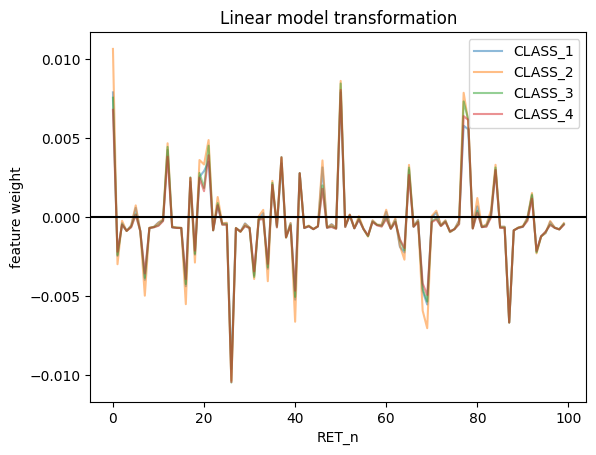

In [451]:
weights_139 = pca.components_.T @ beta + m


plt.plot(range(100),weights_139[0:-3:4],alpha=0.5,label="CLASS_1")
plt.plot(range(100),weights_139[1:-2:4],alpha=0.5,label="CLASS_2")
plt.plot(range(100),weights_139[2:-1:4],alpha=0.5,label="CLASS_3")
plt.plot(range(100),weights_139[3::4],alpha=0.5,label="CLASS_4")
plt.ylim(-max(weights_139)-max(weights_139)/10, max(weights_139)+ max(weights_139)/10)
plt.axhline(y=0,c="black")
plt.title("Linear model transformation")
plt.ylabel("feature weight")
plt.xlabel("RET_n")

plt.legend(loc="upper right")


Okay, this is much more interpretable! Again, seems like returns weighted with `CLASS_2` returns tend to have a larger predictive power for this particular return which as explained at the beggining this is likely to do with the fact that its the class the closest with the average. From this data we can extract which are the top 10 returns that contribute the most to our target returns.

In [480]:
calss_1_f = list(np.flip(np.argsort(class_2_w,axis=0))[0:10][:,0])
calss_1_f

[0, 50, 77, 78, 21, 12, 37, 19, 46, 20]

Text(0, 0.5, 'abs(Weight)')

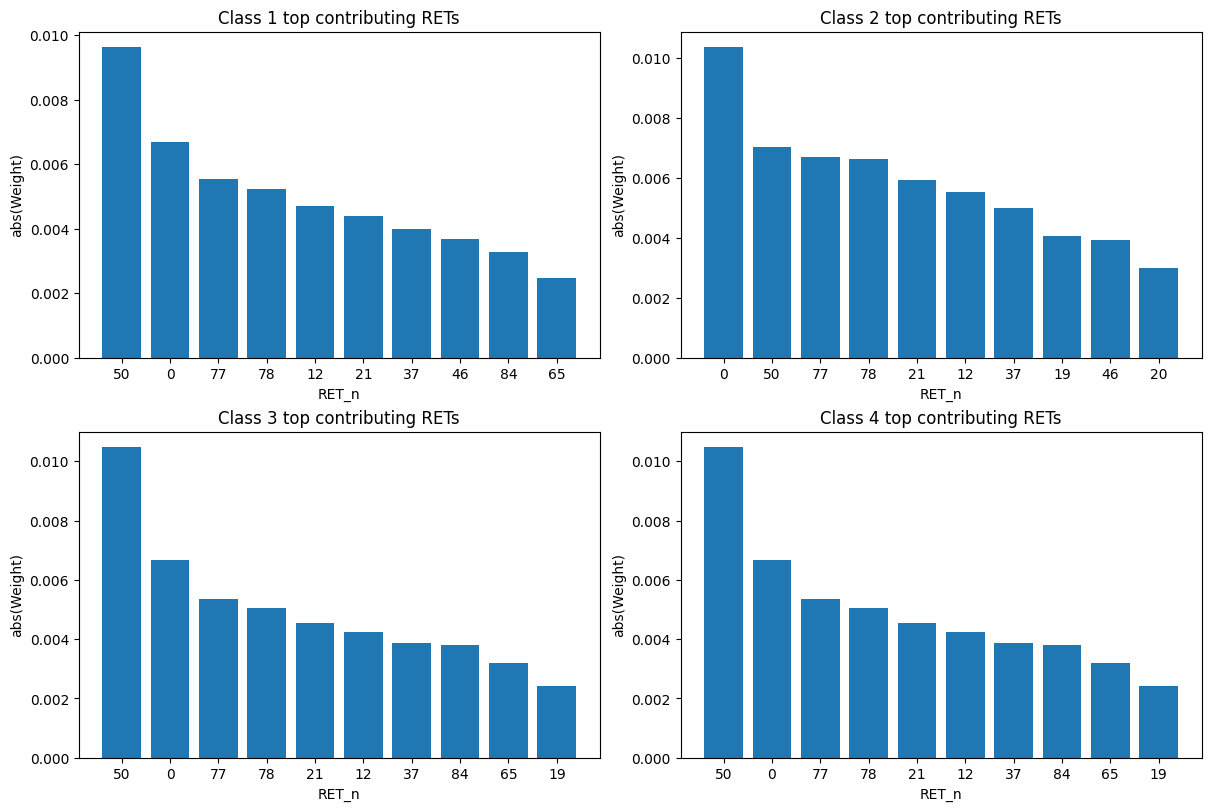

In [495]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), layout='constrained')
class_1_w = weights_139[0:-3:4]
class_2_w = weights_139[1:-2:4]
class_3_w = weights_139[2:-1:4]
class_4_w = weights_139[3::4]

calss_1_f = list(np.flip(np.argsort(class_1_w,axis=0))[0:10][:,0])
calss_1_f = [str(item) for item in calss_1_f]
class_1_w_sorted = np.abs(np.sort(class_1_w,axis=0)[0:10][:,0])
axs[0,0].set_title("Class 1 top contributing RETs")
axs[0,0].bar(calss_1_f,class_1_w_sorted)
axs[0,0].set_xlabel("RET_n")
axs[0,0].set_ylabel("abs(Weight)")

calss_2_f = list(np.flip(np.argsort(class_2_w,axis=0))[0:10][:,0])
calss_2_f = [str(item) for item in calss_2_f]
class_2_w_sorted = np.abs(np.sort(class_2_w,axis=0)[0:10][:,0])
axs[0,1].set_title("Class 2 top contributing RETs")
axs[0,1].bar(calss_2_f,class_2_w_sorted)
axs[0,1].set_xlabel("RET_n")
axs[0,1].set_ylabel("abs(Weight)")

calss_3_f = list(np.flip(np.argsort(class_3_w,axis=0))[0:10][:,0])
calss_3_f = [str(item) for item in calss_3_f]
class_3_w_sorted = np.abs(np.sort(class_3_w,axis=0)[0:10][:,0])
axs[1,0].set_title("Class 3 top contributing RETs")
axs[1,0].bar(calss_3_f,class_3_w_sorted)
axs[1,0].set_xlabel("RET_n")
axs[1,0].set_ylabel("abs(Weight)")

calss_4_f = list(np.flip(np.argsort(class_4_w,axis=0))[0:10][:,0])
calss_4_f = [str(item) for item in calss_4_f]
class_4_w_sorted = np.abs(np.sort(class_4_w,axis=0)[0:10][:,0])
axs[1,1].set_title("Class 4 top contributing RETs")
axs[1,1].bar(calss_3_f,class_3_w_sorted)
axs[1,1].set_xlabel("RET_n")
axs[1,1].set_ylabel("abs(Weight)")

So `RET_0`, `RET_50` and `RET_77` are the most significant. 

We could be a bit more careful and adjust this by the mean of each return but the idea is the same so we will leave this short analysis here. 

## Addendum: pre-standarsing the returns
It is worth noting that standarising the returns before weighting them does not improve the model accurancy: in fact one could argue it makes it worse by making it more noisy. This is the reason we have decided not to pre-standarise the return data.

0.008333333333333333
0.016666666666666666
0.024999999999999998
0.03333333333333333
0.041666666666666664
0.049999999999999996


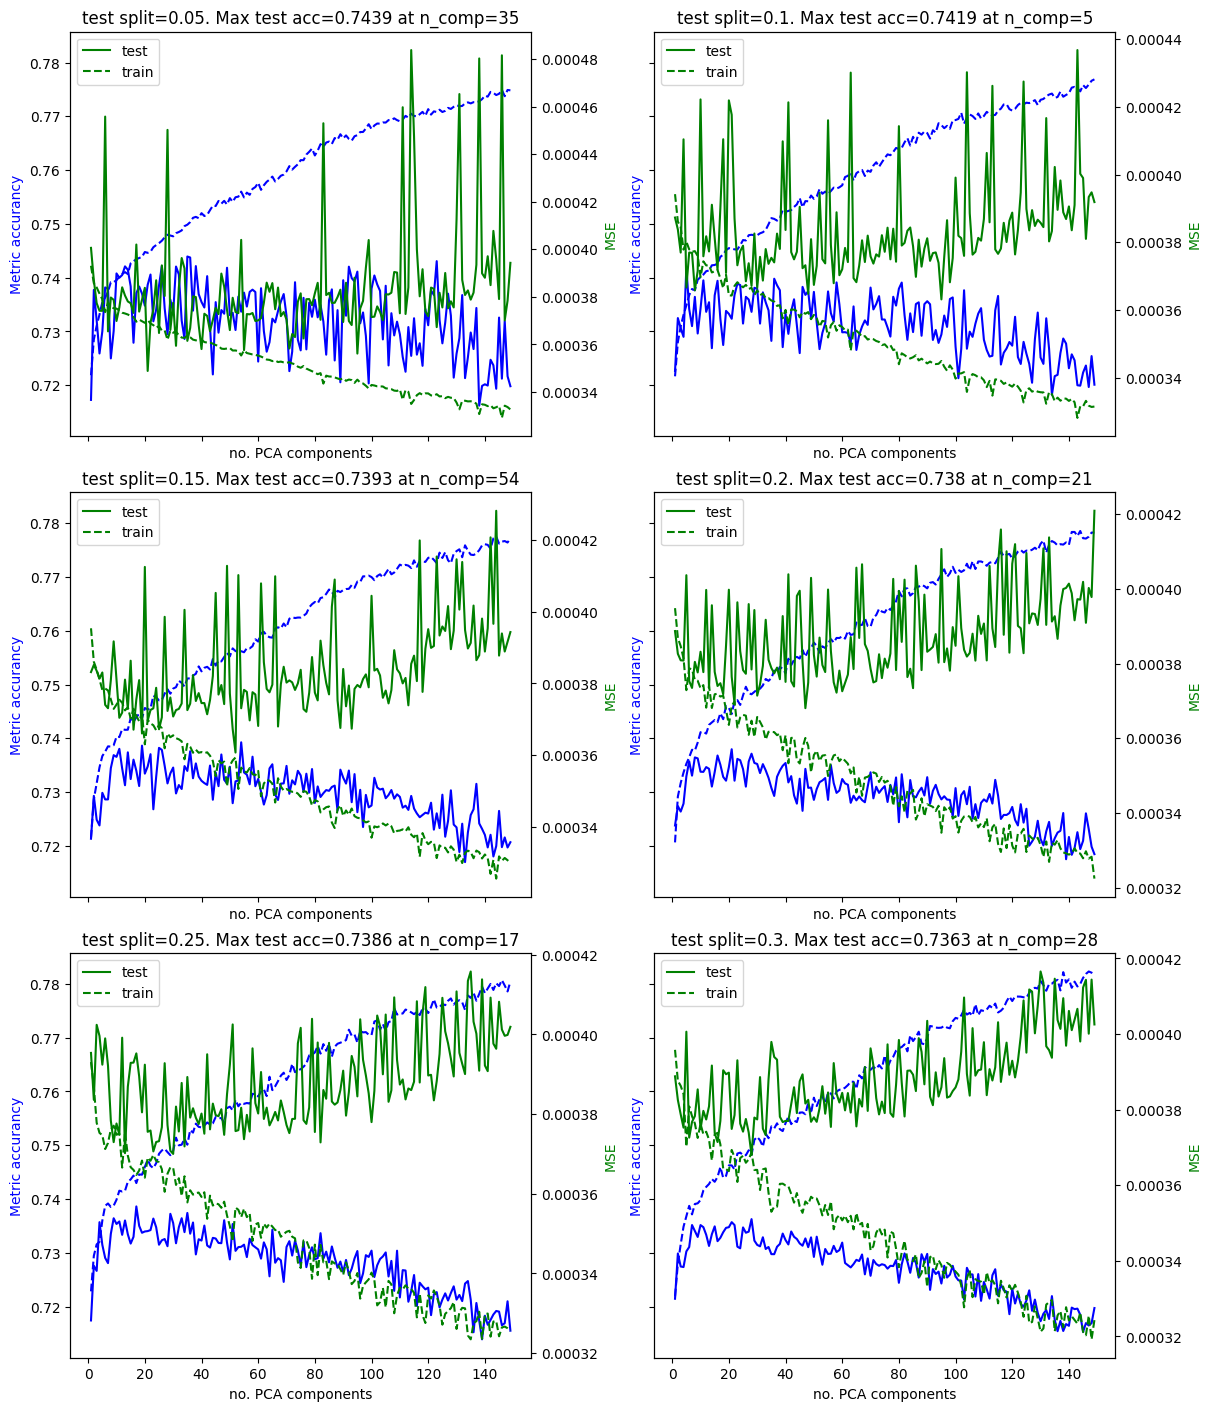

In [370]:
percent_ls = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
n_pca_comp_ls = list(range(1,150,1))
mse_tot_test_ls_ls = []
mse_tot_train_ls_ls = []
test_accu_ls_ls = []
train_accu_ls_ls = []
for percent in percent_ls:
    test_perc = percent
    mse_tot_test_ls = []
    mse_tot_train_ls = []
    test_accu_ls = []
    train_accu_ls = []
    for n_pca_comp in n_pca_comp_ls:
        test_accu, train_accu, mse_tot_test, mse_tot_train = fast_linear_model_stats(model_PCAs,df_x_train,df_y_train,test_perc,n_pca_comp)
        test_accu_ls.append(test_accu)
        train_accu_ls.append(train_accu)
        mse_tot_test_ls.append(mse_tot_test)
        mse_tot_train_ls.append(mse_tot_train)
        # print(n_pca_comp/250, test_accu)

    test_accu_ls_ls.append(test_accu_ls)
    train_accu_ls_ls.append(train_accu_ls)
    mse_tot_test_ls_ls.append(mse_tot_test_ls)
    mse_tot_train_ls_ls.append(mse_tot_train_ls)
    print(percent/len(percent_ls))


fig, axs = plt.subplots(3, 2, figsize=(12, 14), layout='constrained',sharex=True,sharey=True)
i=0
for ax in axs.flat:
    test_perc = percent_ls[i]
    mse_tot_test_ls = mse_tot_test_ls_ls[i]
    mse_tot_train_ls = mse_tot_train_ls_ls[i]
    test_accu_ls = test_accu_ls_ls[i]
    train_accu_ls = train_accu_ls_ls[i]
    i += 1

    ax_twin = ax.twinx()

    ax.plot(n_pca_comp_ls,test_accu_ls, label="test",c="blue")
    ax.plot(n_pca_comp_ls,train_accu_ls, label="train",ls="dashed",c="blue")
    ax.set_ylabel('Metric accurancy',c="blue")

    ax_twin.plot(n_pca_comp_ls,mse_tot_test_ls, label="test",c="green")
    ax_twin.plot(n_pca_comp_ls,mse_tot_train_ls, label="train",ls="dashed",c="green")
    ax_twin.set_ylabel('MSE',c="green")

    ax.set_xlabel("no. PCA components")
    plt.title("test split="+str(test_perc)+". Max test acc="+str(round(max(test_accu_ls),4))+" at n_comp="+str(n_pca_comp_ls[test_accu_ls.index(max(test_accu_ls))]))
    plt.legend()

plt.show()

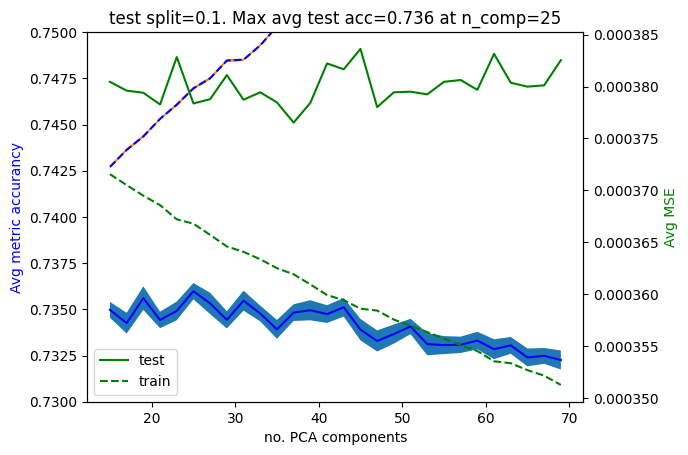

In [369]:
test_perc = 0.1

split_realisations = 50
n_pca_comp_ls = list(range(15,70,2))

test_mse_array = np.zeros((len(n_pca_comp_ls), split_realisations))
train_mse_array = np.zeros((len(n_pca_comp_ls), split_realisations))
test_accu_array = np.zeros((len(n_pca_comp_ls), split_realisations))
train_accu_array = np.zeros((len(n_pca_comp_ls), split_realisations))

for j in range(split_realisations):
    for (k,n_pca_comp) in enumerate(n_pca_comp_ls):
        test_accu, train_accu, mse_tot_test, mse_tot_train = fast_linear_model_stats(model_PCAs,df_x_train,df_y_train,test_perc,n_pca_comp)
        test_mse_array[k,j] = mse_tot_test
        train_mse_array[k,j] = mse_tot_train
        test_accu_array[k,j] = test_accu
        train_accu_array[k,j] = train_accu

    print(j/split_realisations)


# DELETE

avg_test_mse = np.mean(test_mse_array,axis=1)
avg_train_mse = np.mean(train_mse_array,axis=1)
avg_test_accu = np.mean(test_accu_array,axis=1)
avg_train_accu = np.mean(train_accu_array,axis=1)

err_test_mse  = np.std(test_mse_array, axis=1) / np.sqrt(split_realisations)
err_train_mse  = np.std(train_mse_array, axis=1) / np.sqrt(split_realisations)
err_test_accu = np.std(test_accu_array, axis=1) / np.sqrt(split_realisations)
err_train_accu  = np.std(train_accu_array, axis=1) / np.sqrt(split_realisations)


fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(n_pca_comp_ls,avg_test_accu, label="test",c="blue")
ax1.fill_between(n_pca_comp_ls, avg_test_accu-err_test_accu, avg_test_accu+err_test_accu)

ax1.plot(n_pca_comp_ls,avg_train_accu, label="train",ls="dashed",c="blue")
ax1.fill_between(n_pca_comp_ls, avg_train_accu-err_train_accu, avg_train_accu+err_train_accu)

ax1.set_ylim(0.73,0.75)

ax1.set_ylabel('Avg metric accurancy',c="blue")

ax2.plot(n_pca_comp_ls,avg_test_mse, label="test",c="green")
ax1.fill_between(n_pca_comp_ls, avg_test_mse-err_test_mse, avg_test_mse+err_test_mse)

ax2.plot(n_pca_comp_ls,avg_train_mse, label="train",ls="dashed",c="green")
ax1.fill_between(n_pca_comp_ls, avg_train_mse-err_train_mse, avg_train_mse+err_train_mse)

ax2.set_ylabel('Avg MSE',c="green")

ax1.set_xlabel("no. PCA components")
plt.title("test split="+str(test_perc)+". Max avg test acc="+str(round(max(avg_test_accu),4))+" at n_comp="+str(n_pca_comp_ls[list(avg_test_accu).index(max(avg_test_accu))]))
plt.legend()
plt.show()

Text(0.5, 1.0, 'Intercept = -1.6852234148115668e-05')

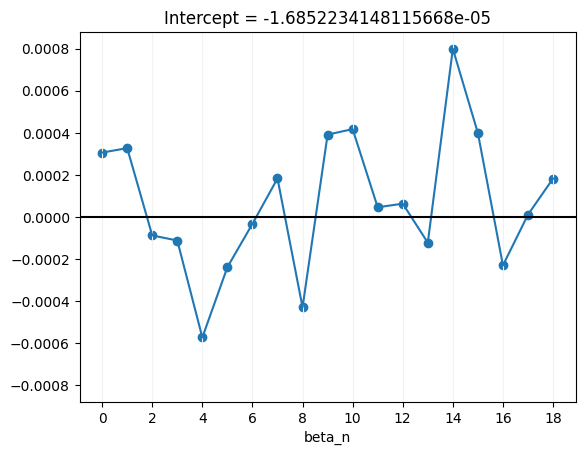

In [371]:
# again we pick 139 as our example asset.
X_train_139, Y_train_139 = data_to_train(X_train,Y_train,X_supp,139)

pca = PCA(n_components=19) # best test
pca.fit( X_train_139 )
X_train_139_PCA = pca.transform(X_train_139)

# add intercept 
X_train_139_PCA = np.hstack((X_train_139_PCA, np.ones((1,X_train_139_PCA.shape[0])).T))

# no regu
betas = inv( X_train_139_PCA.T @ X_train_139_PCA ) @ X_train_139_PCA.T @ Y_train_139

m, beta = betas[0], betas[1:]

plt.plot(beta)
plt.scatter(range(len(beta)),beta)
plt.axhline(y=0,c="black")
plt.xticks(range(0,len(beta),2))
plt.ylim(-max(beta)-max(beta)/10,max(beta)+max(beta)/10)
plt.xlabel("PCA component n")
plt.xlabel("beta_n")
plt.grid(axis='x', color='0.95')
plt.title("Intercept = "+str(m[0]))


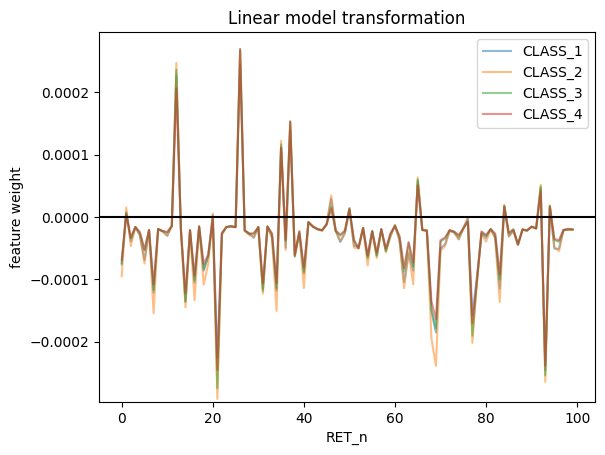

In [374]:
weights_139 = pca.components_.T @ beta + m


plt.plot(range(100),weights_139[0:-3:4],alpha=0.5,label="CLASS_1")
plt.plot(range(100),weights_139[1:-2:4],alpha=0.5,label="CLASS_2")
plt.plot(range(100),weights_139[2:-1:4],alpha=0.5,label="CLASS_3")
plt.plot(range(100),weights_139[3::4],alpha=0.5,label="CLASS_4")
plt.ylim(-max(weights_139)-max(weights_139)/10, max(weights_139)+ max(weights_139)/10)
plt.axhline(y=0,c="black")
plt.title("Linear model transformation")
plt.ylabel("feature weight")
plt.xlabel("RET_n")

plt.legend(loc="upper right")


---
---
---
---

# Further models and ideas tested (inferior performance) 

Here's a rather undocumented set of further ideas tested. From simply adding regularisation to the above model all the way to deep learning models passing by classification algorithms like random forests. Perhaps the only place I saw potential was with random forests (treating the problem as a $+1$, $-1$ classification problem) and deep learning if a genetic algorithm can be made to work (the given metric is non differentiable so this slightly dificulted my attemps and could be overcomed by a genetic algorith which does not rely on gradients).

In [ ]:
percent_ls = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

n_pca_comp_ls = list(range(1,150,1))
# mse_tot_test_ls_ls = []
# mse_tot_train_ls_ls = []
# test_accu_ls_ls = []
# train_accu_ls_ls = []
for percent in percent_ls:
    test_perc = percent
    mse_tot_test_ls = []
    mse_tot_train_ls = []
    test_accu_ls = []
    train_accu_ls = []
    for n_pca_comp in n_pca_comp_ls:
        test_accu, train_accu, mse_tot_test, mse_tot_train = linear_model_stats(model_PCAs,X_train,Y_train,X_supp,test_perc,n_pca_comp)
        test_accu_ls.append(test_accu)
        train_accu_ls.append(train_accu)
        mse_tot_test_ls.append(mse_tot_test)
        mse_tot_train_ls.append(mse_tot_train)
        # print(n_pca_comp/250, test_accu)

    test_accu_ls_ls.append(test_accu_ls)
    train_accu_ls_ls.append(train_accu_ls)
    mse_tot_test_ls_ls.append(mse_tot_test_ls)
    mse_tot_train_ls_ls.append(mse_tot_train_ls)
    print(percent/len(percent_ls))

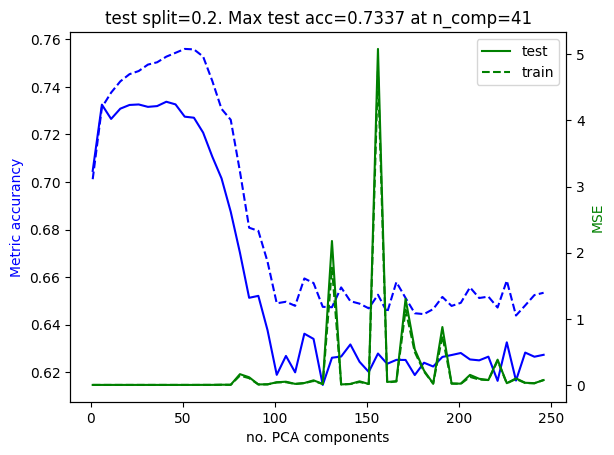

In [377]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(n_pca_comp_ls,test_accu_ls, label="test",c="blue")
ax1.plot(n_pca_comp_ls,train_accu_ls, label="train",ls="dashed",c="blue")
ax1.set_ylabel('Metric accurancy',c="blue")

ax2.plot(n_pca_comp_ls,mse_tot_test_ls, label="test",c="green")
ax2.plot(n_pca_comp_ls,mse_tot_train_ls, label="train",ls="dashed",c="green")
ax2.set_ylabel('MSE',c="green")

ax1.set_xlabel("no. PCA components")
plt.title("test split="+str(test_perc)+". Max test acc="+str(round(max(test_accu_ls),4))+" at n_comp="+str(n_pca_comp_ls[test_accu_ls.index(max(test_accu_ls))]))
plt.legend()
plt.show()

Look at that phase transition like change in the data at around $100$ components! This makes sense if we remember the discontinuous jump in the spectrum at around that very same point. Beautiful!

Let's be a bit more thorough by looking at what happens as we adjust the test/train split:

In [76]:
percent_ls = list(i/100 for i in range(10,50,5))

n_pca_comp_ls = list(range(1,250,5))
# mse_tot_test_ls_ls = []
# mse_tot_train_ls_ls = []
# test_accu_ls_ls = []
# train_accu_ls_ls = []

for percent in percent_ls:
    test_perc = percent
    mse_tot_test_ls = []
    mse_tot_train_ls = []
    test_accu_ls = []
    train_accu_ls = []
    for n_pca_comp in n_pca_comp_ls:
        test_accu, train_accu, mse_tot_test, mse_tot_train = linear_model_stats(X_train,Y_train,X_supp,test_percent=test_perc,PCA_percent=n_pca_comp)
        test_accu_ls.append(test_accu)
        train_accu_ls.append(train_accu)
        mse_tot_test_ls.append(mse_tot_test)
        mse_tot_train_ls.append(mse_tot_train)
        # print(n_pca_comp/250, test_accu)

    test_accu_ls_ls.append(test_accu_ls)
    train_accu_ls_ls.append(train_accu_ls)
    mse_tot_test_ls_ls.append(mse_tot_test_ls)
    mse_tot_train_ls_ls.append(mse_tot_train_ls)
    print(percent/.45)

0.22222222222222224
0.3333333333333333
0.4444444444444445
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.888888888888889
1.0


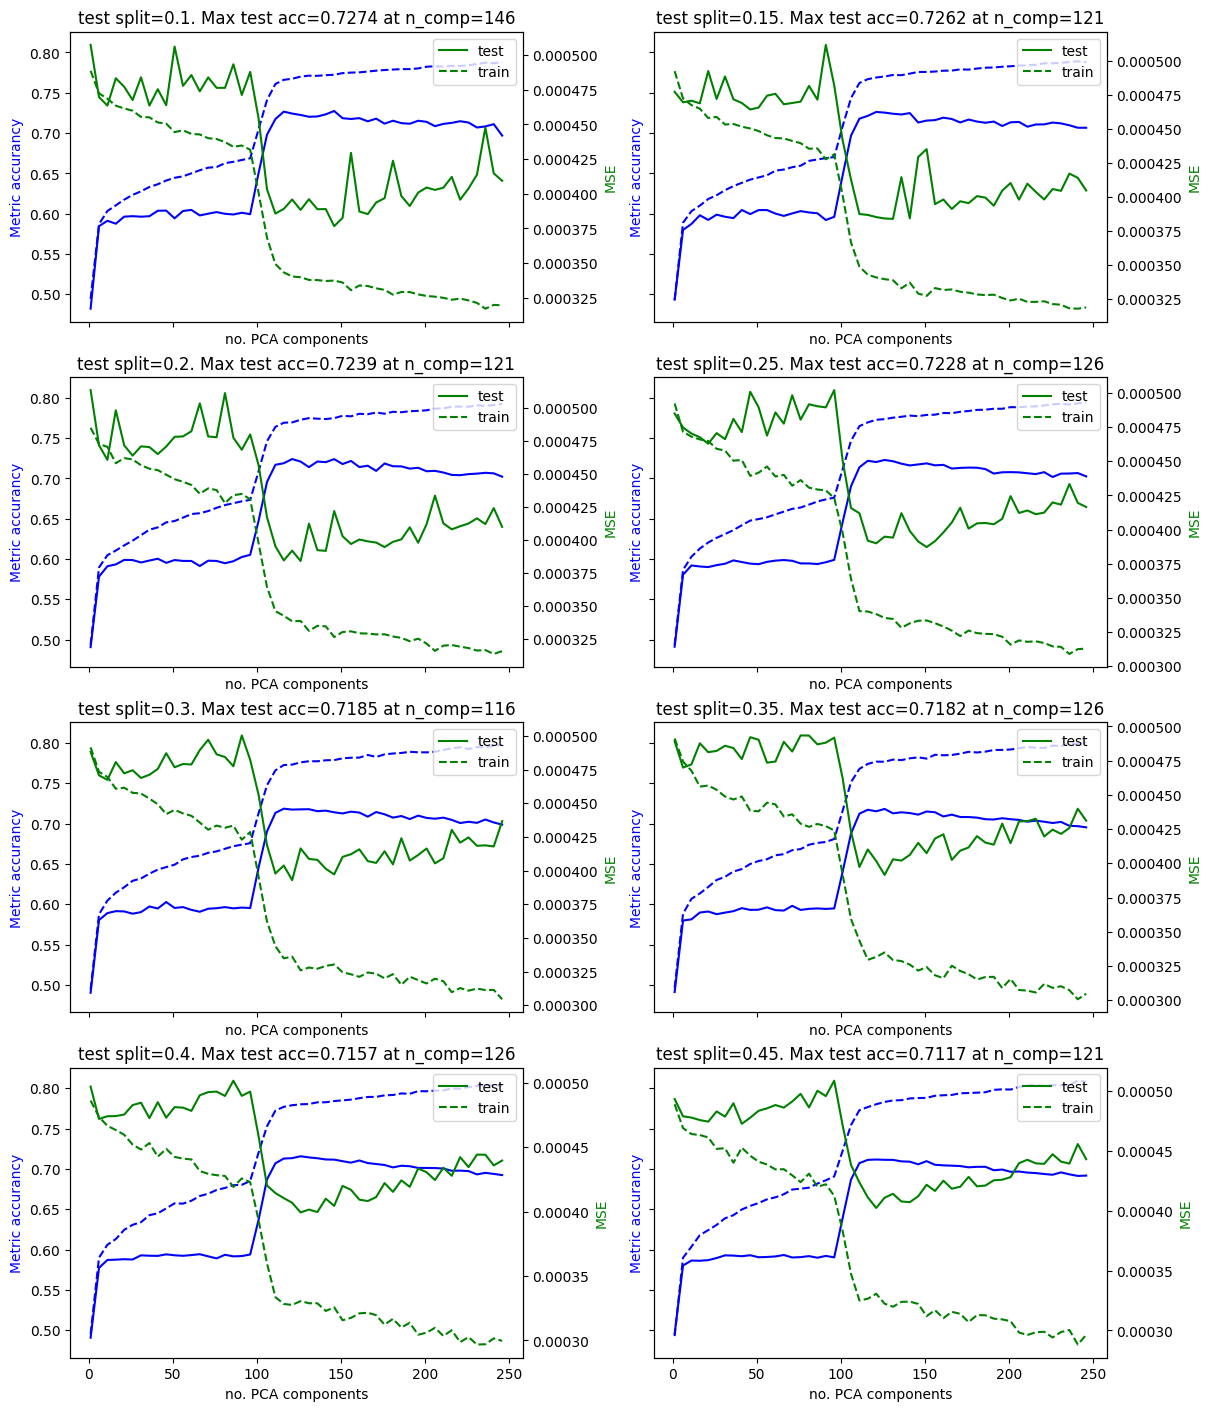

In [91]:

fig, axs = plt.subplots(4, 2, figsize=(12, 14), layout='constrained',sharex=True,sharey=True)
i=0
for ax in axs.flat:
    test_perc = percent_ls[i]
    mse_tot_test_ls = mse_tot_test_ls_ls[i]
    mse_tot_train_ls = mse_tot_train_ls_ls[i]
    test_accu_ls = test_accu_ls_ls[i]
    train_accu_ls = train_accu_ls_ls[i]
    i += 1

    ax_twin = ax.twinx()

    ax.plot(n_pca_comp_ls,test_accu_ls, label="test",c="blue")
    ax.plot(n_pca_comp_ls,train_accu_ls, label="train",ls="dashed",c="blue")
    ax.set_ylabel('Metric accurancy',c="blue")

    ax_twin.plot(n_pca_comp_ls,mse_tot_test_ls, label="test",c="green")
    ax_twin.plot(n_pca_comp_ls,mse_tot_train_ls, label="train",ls="dashed",c="green")
    ax_twin.set_ylabel('MSE',c="green")

    ax.set_xlabel("no. PCA components")
    plt.title("test split="+str(test_perc)+". Max test acc="+str(round(max(test_accu_ls),4))+" at n_comp="+str(n_pca_comp_ls[test_accu_ls.index(max(test_accu_ls))]))
    plt.legend()

plt.show()

So sure, a larger test set makes the data less noisy but it also brings down the test accurancy a bit over a percent. Having said that, it doesnt look like there is any notable qualitative changes across these different test splits. 

All in all, it seems like this model, as it stands, is limited to a $ <73\%$ accurancy when using $\sim 100$ principal components. We could try to push this model a bit further (by perhaps rethinking our feature engenieering or with a more clever loss function) however we cannot resist to see what happens with a deep learning model. With this feature engenieering we did, the data set is no longer as small as we had previously thought since now the data is not simply repeated data due to our weighting process. In the next model we will see we can go the extra mile with deep neural networks and squeeze an extra $1\%$ or $2\%$.

# As a classification

### Random forests


In [19]:
def data_to_train_pd(X_train,Y_train,supp_df,liquid_ID):
    train_df = weight_returns(X_train,supp_df,liquid_ID)
    ID_list = train_df["ID"]
    test_df = Y_train.loc[Y_train['ID'].isin(ID_list)]    
    
    train_array = train_df.drop(columns=["ID"])
    test_array = test_df.drop(columns=["ID"])
    return train_array, test_array

df_x_train = pd.DataFrame()
df_y_train = pd.DataFrame()
for target_ID in X_train["ID_TARGET"].unique():
     df_temp_x, df_temp_y = data_to_train_pd(X_train,Y_train,X_supp,target_ID)
     df_x_train = pd.concat([df_x_train,df_temp_x])
     df_y_train = pd.concat([df_y_train,df_temp_y])
     
df_x_train

,RET_216_0,RET_216_1,RET_216_2,RET_216_3,RET_238_0,RET_238_1,RET_238_2,RET_238_3,RET_45_0,RET_45_1,...,RET_95_2,RET_95_3,RET_162_0,RET_162_1,RET_162_2,RET_162_3,RET_297_0,RET_297_1,RET_297_2,RET_297_3
0,0.002870,0.003778,0.002758,0.002506,0.006588,0.008672,0.006331,0.005526,0.002608,0.003530,...,0.000133,0.000129,-0.001189,-0.001181,-0.000824,-0.000705,-0.020538,-0.022636,-0.018484,-0.016595
100,0.018436,0.024268,0.017716,0.016094,-0.001504,-0.001980,-0.001446,-0.001262,-0.011448,-0.015497,...,-0.001091,-0.001055,0.002120,0.002104,0.001468,0.001257,0.001417,0.001562,0.001275,0.001145
200,-0.008749,-0.011517,-0.008407,-0.007638,0.005322,0.007005,0.005114,0.004464,0.026942,0.036471,...,0.002529,0.002445,0.003585,0.003558,0.002483,0.002125,0.007266,0.008008,0.006539,0.005871
300,-0.023964,-0.031545,-0.023028,-0.020920,-0.002458,-0.003235,-0.002362,-0.002062,-0.004778,-0.006468,...,-0.002648,-0.002560,0.001672,0.001660,0.001158,0.000991,0.006732,0.007419,0.006058,0.005439
400,0.020806,0.027387,0.019992,0.018163,-0.060123,-0.079141,-0.057773,-0.050430,0.000171,0.000231,...,-0.002687,-0.002598,-0.000618,-0.000614,-0.000428,-0.000366,-0.012285,-0.013541,-0.011057,-0.009927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266703,-0.012034,-0.012034,-0.010992,-0.011348,-0.021459,-0.021459,-0.019601,-0.019828,-0.004046,-0.003884,...,0.000539,0.000581,-0.003203,-0.002199,-0.001680,-0.001651,-0.002273,-0.001773,-0.001574,-0.001608
266802,0.001643,0.001643,0.001501,0.001549,0.018795,0.018795,0.017167,0.017367,0.047766,0.045851,...,-0.001797,-0.001937,0.031023,0.021304,0.016272,0.015997,0.001066,0.000831,0.000738,0.000754
266901,0.010200,0.010200,0.009317,0.009619,-0.003231,-0.003231,-0.002952,-0.002986,-0.016627,-0.015961,...,0.001269,0.001368,-0.012262,-0.008420,-0.006431,-0.006322,-0.004896,-0.003819,-0.003391,-0.003464
267000,0.000532,0.000532,0.000486,0.000501,-0.006588,-0.006588,-0.006017,-0.006087,-0.048504,-0.046559,...,-0.002448,-0.002639,-0.008945,-0.006143,-0.004692,-0.004612,-0.000498,-0.000388,-0.000345,-0.000352


In [13]:
from sklearn import ensemble 

def class_accu(y_true,y_pred):
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    sign_sum = 0.5 * np.abs( np.sign(y_true) + np.sign(y_pred) )
    sum_array = np.multiply( np.abs(y_true), sign_sum ) 
    sum_term = np.sum( sum_array )
    norm_term = np.sum( np.abs(y_true) )
    return np.divide( sum_term,norm_term ) 


train_x, test_x, train_y, test_y = train_test_split(df_x_train,df_y_train, test_size=0.1)
y_train_signed, y_test_signed = train_y, test_y

y_train_signed["RET_TARGET"], y_test_signed["RET_TARGET"] = np.sign(y_train_signed["RET_TARGET"]), np.sign(y_test_signed["RET_TARGET"])

# dtr = ensemble.RandomForestRegressor(n_estimators=10,min_samples_leaf=25,max_depth = 20,verbose=2)
# regr = dtr.fit(train_x, y_train_signed)
pred_y =  np.reshape(  regr.predict(test_x), (len(test_y),1))

acc = class_accu(test_y,pred_y)
acc

Okay, looks promising, but can we do better than with our linear regression ? Well, let's see if by tunning the depth of our trees we can fine tune further.

In [14]:
train_x, test_x, train_y, test_y = train_test_split(df_x_train,df_y_train, test_size=0.1)
y_train_signed, y_test_signed = train_y, test_y

y_train_signed["RET_TARGET"], y_test_signed["RET_TARGET"] = np.sign(y_train_signed["RET_TARGET"]), np.sign(y_test_signed["RET_TARGET"])

max_depth_ls = list(range(5,100,5))
acc_ls = []
for m in max_depth_ls:
    dtr = ensemble.RandomForestRegressor(n_estimators=10,max_depth=m)
    regr = dtr.fit(train_x, train_y)
    pred_y = regr.predict(test_x)

    pred_y =  np.reshape(  regr.predict(test_x), (len(test_y),1))
    acc = class_accu(test_y,pred_y) 

    acc_ls.append(acc)
    print(m/max(max_depth_ls), acc)

/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.05263157894736842 0.6175964058405091


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.10526315789473684 0.6392362411081992


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.15789473684210525 0.6452639460876076


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.21052631578947367 0.6420816173717708


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.2631578947368421 0.6344814676151255


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.3157894736842105 0.6244664919505803


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.3684210526315789 0.6228378884312992


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.42105263157894735 0.6213777611381505


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.47368421052631576 0.6231374017222014


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.5263157894736842 0.6247660052414826


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.5789473684210527 0.6268438786971172


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.631578947368421 0.6272182703107451


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.6842105263157895 0.6264882066641707


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.7368421052631579 0.6241108199176338


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.7894736842105263 0.6233620366903782


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.8421052631578947 0.6232309996256084


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.8947368421052632 0.6242044178210409


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


0.9473684210526315 0.6238300262074129


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


1.0 0.6254399101460127


In [399]:
from sklearn.linear_model import LogisticRegression

def class_accu(y_true,y_pred):
    sign_sum = 0.5 * np.abs( np.sign(y_true) + np.sign(y_pred) )
    sum_array = np.multiply( np.abs(y_true), sign_sum ) 
    sum_term = np.sum( sum_array )
    norm_term = np.sum( np.abs(y_true) )
    return np.divide( sum_term,norm_term ) 

train_x, test_x, train_y, test_y = train_test_split(df_x_train,df_y_train, test_size=0.1)
y_train_signed, y_test_signed = train_y, test_y

y_train_signed["RET_TARGET"], y_test_signed["RET_TARGET"] = np.sign(y_train_signed["RET_TARGET"]), np.sign(y_test_signed["RET_TARGET"])

clf = LogisticRegression(penalty="l1",solver="liblinear").fit(train_x, y_train_signed)

pred_y = np.reshape( clf.predict(test_x), (len(pred_y),1))

acc = class_accu(test_y,pred_y)
acc

/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/sklearn/utils/validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


RET_TARGET    0.622613
dtype: float64

In [123]:
binary_cross = tf.keras.losses.BinaryCrossentropy()

def custom_binary_cross(y_true,y_pred):
    y_true_bin = ( tf.math.sign(y_true) + 1 )/2
    return tf.math.multiply(binary_cross(y_true_bin,y_pred),tf.abs(y_true))

y_true_test = tf.constant([1.0, -3.5, 4.1, 0.1])
y_pred_test = tf.constant([0.5, -2, -3, 0.01])
custom_binary_cross(y_true_test,y_pred_test)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 5.1808143, 18.13285  , 21.241339 ,  0.5180814], dtype=float32)>

In [124]:
def sign_cnt(x,k=1e3):
    return 2*(tf.sigmoid(x*k)-0.5)

def abs_cnt(x,k=1e3):
    return x*tf.sigmoid(x*k)-x*tf.sigmoid(-x*k) 

def custom_acc(y_true,y_pred):
    sign_sum = 0.5 * tf.abs( tf.math.sign(y_true) + tf.math.sign(y_pred) )
    sum_array = tf.math.multiply( tf.abs(y_true), sign_sum ) 
    sum_term = tf.reduce_sum( sum_array )
    norm_term = tf.reduce_sum( tf.abs(y_true) )
    return tf.math.divide( sum_term,norm_term )

def class_accu(y_true,y_pred):
    sign_sum = 0.5 * np.abs( np.sign(y_true) + np.sign(y_pred) )
    sum_array = np.multiply( np.abs(y_true), sign_sum ) 
    sum_term = np.sum( sum_array )
    norm_term = np.sum( np.abs(y_true) )
    return np.divide( sum_term,norm_term ) 

def custom_loss(y_true,y_pred):
    sign_sum = 0.5 * abs_cnt( sign_cnt(y_true) + sign_cnt(y_pred) )
    sum_array = tf.math.multiply( tf.abs(y_true), sign_sum ) 
    sum_term = tf.reduce_sum( sum_array )
    norm_term = tf.reduce_sum( tf.abs(y_true) )
    return -tf.math.divide( sum_term,norm_term ) 

binary_cross = tf.keras.losses.BinaryCrossentropy(from_logits=False)
def custom_binary_cross(y_true,y_pred):
    y_true_bin = ( tf.math.sign(y_true) + 1 )/2
    return tf.math.multiply(binary_cross(y_true_bin,y_pred),tf.abs(y_true))


train_x, test_x, train_y, test_y = train_test_split(df_x_train,df_y_train, test_size=0.1)

train_y_signed = train_y.copy()
train_y_signed["RET_TARGET"] = (np.sign(train_y["RET_TARGET"]) + 1)/2
test_y_signed = test_y.copy()
test_y_signed["RET_TARGET"] = (np.sign(test_y["RET_TARGET"]) + 1)/2

model = keras.Sequential([
    layers.Dense(400, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(100, activation='relu'), 
    # layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(1,activation="sigmoid"),
])

L_rate = 1e-4

binary_accu = tf.keras.metrics.BinaryAccuracy()

model.compile(loss=custom_binary_cross,
            optimizer=tf.keras.optimizers.legacy.Adam(L_rate), metrics=[binary_accu])


checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="binary_accuracy", 
    # monitor="custom_acc", # save best custom_acc
    # monitor="mse", # save best custom_acc
    mode='max', # the larger custom_acc the better
    save_weights_only=True,
    save_best_only=True
    )


## if comented is because I wanted to delete the verbose output of the fitter.
history = model.fit(train_x, train_y_signed, validation_data=(test_x,test_y_signed), epochs=200,verbose=2,batch_size=100, callbacks=[model_checkpoint_callback])

# model.predict(test_x)
# test_y

Epoch 1/200
2404/2404 - 4s - loss: 0.2675 - binary_accuracy: 0.4757 - val_loss: 0.2661 - val_binary_accuracy: 0.4795 - 4s/epoch - 2ms/step
Epoch 2/200
2404/2404 - 4s - loss: 0.2651 - binary_accuracy: 0.4756 - val_loss: 0.2659 - val_binary_accuracy: 0.4795 - 4s/epoch - 2ms/step
Epoch 3/200
2404/2404 - 4s - loss: 0.2648 - binary_accuracy: 0.4756 - val_loss: 0.2656 - val_binary_accuracy: 0.4795 - 4s/epoch - 2ms/step
Epoch 4/200
2404/2404 - 4s - loss: 0.2644 - binary_accuracy: 0.4756 - val_loss: 0.2654 - val_binary_accuracy: 0.4795 - 4s/epoch - 2ms/step
Epoch 5/200
2404/2404 - 4s - loss: 0.2641 - binary_accuracy: 0.4756 - val_loss: 0.2652 - val_binary_accuracy: 0.4795 - 4s/epoch - 2ms/step
Epoch 6/200
2404/2404 - 4s - loss: 0.2638 - binary_accuracy: 0.4756 - val_loss: 0.2651 - val_binary_accuracy: 0.4795 - 4s/epoch - 2ms/step
Epoch 7/200
2404/2404 - 4s - loss: 0.2636 - binary_accuracy: 0.4756 - val_loss: 0.2649 - val_binary_accuracy: 0.4795 - 4s/epoch - 2ms/step
Epoch 8/200
2404/2404 - 4s 

KeyboardInterrupt: 

In [130]:
model.load_weights(checkpoint_filepath)
y_pred = np.sign(model.predict(test_x) - 0.5)
print(y_pred,test_y)
class_accu(test_y,y_pred)

835/835 [==============================] - 0s 557us/step
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]         RET_TARGET
46543    -0.028975
174467    0.021741
96265    -0.000382
104283   -0.005367
175816   -0.039988
...            ...
163075   -0.004709
241806    0.003969
27659    -0.010495
132936   -0.006145
10702    -0.006305

[26710 rows x 1 columns]


/Users/alex/Documents/Projects/QRT_challlenge_2/QRT_2/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


RET_TARGET    0.516637
dtype: float64

In [129]:
test_y

,RET_TARGET
46543,-0.028975
174467,0.021741
96265,-0.000382
104283,-0.005367
175816,-0.039988
...,...
163075,-0.004709
241806,0.003969
27659,-0.010495
132936,-0.006145


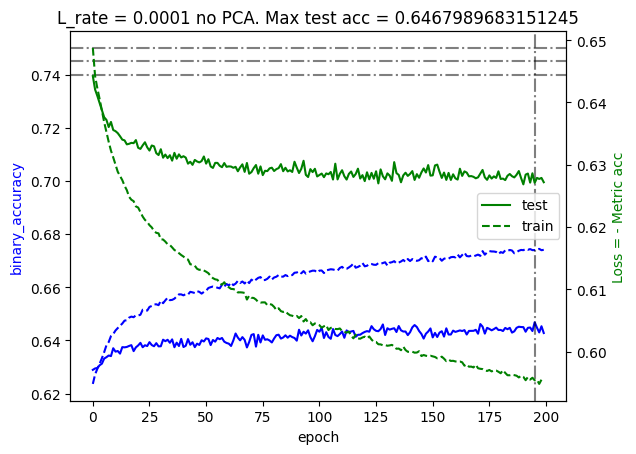

In [116]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(history.history["binary_accuracy"],label="train",ls="dashed",c="blue")
ax1.plot(history.history['val_binary_accuracy'],label="test",c="blue")
ax1.set_ylabel('binary_accuracy',c="blue")

ax2.plot(history.history["val_loss"], label="test",c="green")
ax2.plot(history.history["loss"], label="train",ls="dashed",c="green")
ax2.set_ylabel('Loss = - Metric acc',c="green")

ax1.set_title("L_rate = "+str(L_rate)+" no PCA. Max test acc = "+str(max(history.history['val_binary_accuracy'])))

ax1.axhline(0.74,c="black",ls="dashdot",alpha=0.5)
ax1.axhline(0.745,c="black",ls="dashdot",alpha=0.5)
ax1.axhline(0.75,c="black",ls="dashdot",alpha=0.5)
ax1.axvline(history.history["val_binary_accuracy"].index(max(history.history["val_binary_accuracy"])),c="black",ls="dashdot",alpha=0.5)

# ax1.set_yscale("log")
# axs[i].set_yscale("log")

ax1.set_xlabel('epoch')
plt.legend( loc='center right')
plt.show()

## Deep learning model
We will test a particular deep learning model with and without PCA. We first define some helper functions to apply all the feature engenieering we did to the entire data set:

In [53]:
def data_to_train_pd(X_train,Y_train,supp_df,liquid_ID):
    train_df = weight_returns(X_train,supp_df,liquid_ID)
    ID_list = train_df["ID"]
    test_df = Y_train.loc[Y_train['ID'].isin(ID_list)]    
    
    train_array = train_df.drop(columns=["ID"])
    test_array = test_df.drop(columns=["ID"])
    return train_array, test_array

df_x_train = pd.DataFrame()
df_y_train = pd.DataFrame()
for target_ID in X_train["ID_TARGET"].unique():
     df_temp_x, df_temp_y = data_to_train_pd(X_train,Y_train,X_supp,target_ID)
     df_x_train = pd.concat([df_x_train,df_temp_x])
     df_y_train = pd.concat([df_y_train,df_temp_y])
     
df_x_train

,RET_216_0,RET_216_1,RET_216_2,RET_216_3,RET_238_0,RET_238_1,RET_238_2,RET_238_3,RET_45_0,RET_45_1,...,RET_95_2,RET_95_3,RET_162_0,RET_162_1,RET_162_2,RET_162_3,RET_297_0,RET_297_1,RET_297_2,RET_297_3
0,0.002870,0.003778,0.002758,0.002506,0.006588,0.008672,0.006331,0.005526,0.002608,0.003530,...,0.000133,0.000129,-0.001189,-0.001181,-0.000824,-0.000705,-0.020538,-0.022636,-0.018484,-0.016595
100,0.018436,0.024268,0.017716,0.016094,-0.001504,-0.001980,-0.001446,-0.001262,-0.011448,-0.015497,...,-0.001091,-0.001055,0.002120,0.002104,0.001468,0.001257,0.001417,0.001562,0.001275,0.001145
200,-0.008749,-0.011517,-0.008407,-0.007638,0.005322,0.007005,0.005114,0.004464,0.026942,0.036471,...,0.002529,0.002445,0.003585,0.003558,0.002483,0.002125,0.007266,0.008008,0.006539,0.005871
300,-0.023964,-0.031545,-0.023028,-0.020920,-0.002458,-0.003235,-0.002362,-0.002062,-0.004778,-0.006468,...,-0.002648,-0.002560,0.001672,0.001660,0.001158,0.000991,0.006732,0.007419,0.006058,0.005439
400,0.020806,0.027387,0.019992,0.018163,-0.060123,-0.079141,-0.057773,-0.050430,0.000171,0.000231,...,-0.002687,-0.002598,-0.000618,-0.000614,-0.000428,-0.000366,-0.012285,-0.013541,-0.011057,-0.009927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266703,-0.012034,-0.012034,-0.010992,-0.011348,-0.021459,-0.021459,-0.019601,-0.019828,-0.004046,-0.003884,...,0.000539,0.000581,-0.003203,-0.002199,-0.001680,-0.001651,-0.002273,-0.001773,-0.001574,-0.001608
266802,0.001643,0.001643,0.001501,0.001549,0.018795,0.018795,0.017167,0.017367,0.047766,0.045851,...,-0.001797,-0.001937,0.031023,0.021304,0.016272,0.015997,0.001066,0.000831,0.000738,0.000754
266901,0.010200,0.010200,0.009317,0.009619,-0.003231,-0.003231,-0.002952,-0.002986,-0.016627,-0.015961,...,0.001269,0.001368,-0.012262,-0.008420,-0.006431,-0.006322,-0.004896,-0.003819,-0.003391,-0.003464
267000,0.000532,0.000532,0.000486,0.000501,-0.006588,-0.006588,-0.006017,-0.006087,-0.048504,-0.046559,...,-0.002448,-0.002639,-0.008945,-0.006143,-0.004692,-0.004612,-0.000498,-0.000388,-0.000345,-0.000352


In [63]:
df_y_train

,RET_TARGET
0,-0.022351
100,0.008354
200,0.012218
300,-0.004456
400,0.008788
...,...
266703,0.041931
266802,-0.019130
266901,0.015095
267000,-0.009511


With that out of the way, we will now "analytically continue" the custom metric on which the challenge is assed to maximise our chances of performing well. This is necesary as the given metric is not differentiable ($\textrm{sign}(\cdot)$ and $|\cdot|$ functions are not differentiable). The idea is very simple:
$$
\textrm{sign}(x) \xrightarrow{A.C} 2\sigma(kx)-1 \quad \text{ and } \quad |x| \xrightarrow{A.C}  x\sigma(kx)-x\sigma(-kx),
$$
where $\sigma(kx)$ is the sigmoid function with $k$ playing the role of a smoothing parameter (the larger it is the sharper the fit). We code those two up and we create a `custom_loss` function by simply minimising the negative of the given metric $-f(y^t,y^p)$.

In [293]:
def sign_cnt(x,k=1e3):
    return 2*(tf.sigmoid(x*k)-0.5)

def abs_cnt(x,k=1e3):
    return x*tf.sigmoid(x*k)-x*tf.sigmoid(-x*k) 

def custom_acc(y_true,y_pred):
    sign_sum = 0.5 * tf.abs( tf.math.sign(y_true) + tf.math.sign(y_pred) )
    sum_array = tf.math.multiply( tf.abs(y_true), sign_sum ) 
    sum_term = tf.reduce_sum( sum_array )
    norm_term = tf.reduce_sum( tf.abs(y_true) )
    return tf.math.divide( sum_term,norm_term )

def custom_loss(y_true,y_pred):
    sign_sum = 0.5 * abs_cnt( sign_cnt(y_true) + sign_cnt(y_pred) )
    sum_array = tf.math.multiply( tf.abs(y_true), sign_sum ) 
    sum_term = tf.reduce_sum( sum_array )
    norm_term = tf.reduce_sum( tf.abs(y_true) )
    return -tf.math.divide( sum_term,norm_term ) 

y_true_test = tf.constant([1.0, -3.5, 4.1, 0.1])
y_pred_test = tf.constant([0.5, -2, -3, 0.01])
print( custom_acc(y_true_test,y_pred_test) )
print( custom_loss(y_true_test,y_pred_test) )

tf.Tensor(0.52873564, shape=(), dtype=float32)
tf.Tensor(-0.52873516, shape=(), dtype=float32)


Which as you can see in the two print statements above, it very nicely approximates the exact value for large $k$. For the actual deep learning model we follow a standard setup with some hidden layers, `relu` as activation function and some dropout to prevent overfitting. 

In [302]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers


model = keras.Sequential([
    tf.keras.layers.InputLayer(400),
    # layers.Dense(400, activation='linear'),
    # layers.Dense(100, activation='relu'),
    layers.Dense(500, activation='relu'),
    layers.Dense(300, activation='relu'),
    layers.Dropout(.1),
    layers.Dense(1,activation="linear") # linear is the default
])

L_rate = 1e-5
# model.compile(loss="mse",
#             optimizer=tf.keras.optimizers.legacy.Adam(L_rate), metrics=["mse",custom_acc])

model.compile(loss=custom_loss,
            optimizer=tf.keras.optimizers.legacy.Adam(L_rate), metrics=[custom_acc])

checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="custom_acc", # save best custom_acc
    # monitor="mse", # save best custom_acc
    mode='max', # the larger custom_acc the better
    save_weights_only=True,
    save_best_only=True
    )


# pca = PCA(n_components=200) # explain % of variability
# pca.fit( df_x_train )
# df_x_train_pca = pca.transform(df_x_train)

idx_shuffled = np.random.permutation(df_x_train.index)
df_x_train = df_x_train.reindex(idx_shuffled)
df_y_train = df_y_train.reindex(idx_shuffled)

## if comented is because I wanted to delete the verbose output of the fitter.
history = model.fit(df_x_train, df_y_train, validation_split = 0.1, epochs=100,verbose=2,batch_size=1000, callbacks=[model_checkpoint_callback])

Epoch 1/100
241/241 - 2s - loss: -6.5959e-01 - custom_acc: 0.6612 - val_loss: -6.8553e-01 - val_custom_acc: 0.6864 - 2s/epoch - 8ms/step
Epoch 2/100
241/241 - 2s - loss: -6.8779e-01 - custom_acc: 0.6890 - val_loss: -6.9072e-01 - val_custom_acc: 0.6929 - 2s/epoch - 7ms/step
Epoch 3/100
241/241 - 2s - loss: -6.9246e-01 - custom_acc: 0.6931 - val_loss: -6.9249e-01 - val_custom_acc: 0.6944 - 2s/epoch - 7ms/step
Epoch 4/100
241/241 - 2s - loss: -6.9498e-01 - custom_acc: 0.6959 - val_loss: -6.9267e-01 - val_custom_acc: 0.6937 - 2s/epoch - 6ms/step
Epoch 5/100
241/241 - 2s - loss: -6.9738e-01 - custom_acc: 0.6986 - val_loss: -6.9361e-01 - val_custom_acc: 0.6948 - 2s/epoch - 6ms/step
Epoch 6/100
241/241 - 2s - loss: -6.9846e-01 - custom_acc: 0.6994 - val_loss: -6.9531e-01 - val_custom_acc: 0.6967 - 2s/epoch - 6ms/step
Epoch 7/100
241/241 - 2s - loss: -6.9987e-01 - custom_acc: 0.7008 - val_loss: -6.9603e-01 - val_custom_acc: 0.6976 - 2s/epoch - 7ms/step
Epoch 8/100
241/241 - 2s - loss: -7.0048e

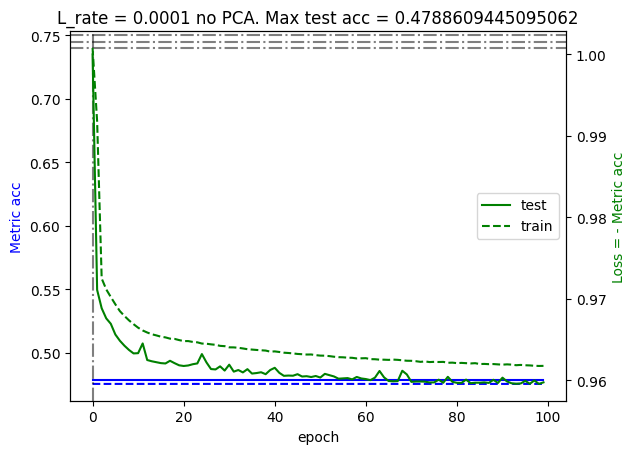

In [43]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(history.history["custom_acc"],label="train",ls="dashed",c="blue")
ax1.plot(history.history['val_custom_acc'],label="test",c="blue")
ax1.set_ylabel('Metric acc',c="blue")

ax2.plot(history.history["val_loss"], label="test",c="green")
ax2.plot(history.history["loss"], label="train",ls="dashed",c="green")
ax2.set_ylabel('Loss = - Metric acc',c="green")

ax1.set_title("L_rate = "+str(L_rate)+" no PCA. Max test acc = "+str(max(history.history['val_custom_acc'])))

ax1.axhline(0.74,c="black",ls="dashdot",alpha=0.5)
ax1.axhline(0.745,c="black",ls="dashdot",alpha=0.5)
ax1.axhline(0.75,c="black",ls="dashdot",alpha=0.5)
ax1.axvline(history.history["val_custom_acc"].index(max(history.history["val_custom_acc"])),c="black",ls="dashdot",alpha=0.5)

# ax1.set_yscale("log")
# axs[i].set_yscale("log")

ax1.set_xlabel('epoch')
plt.legend( loc='center right')
plt.show()

In [299]:
def predict_data_to_test(x_test_df,supp_df,model):
    df_x_test = pd.DataFrame()
    for target_ID in x_test_df["ID_TARGET"].unique():
        df_temp_x =  weight_returns(x_test_df,supp_df,target_ID)
        df_x_test = pd.concat([df_x_test,df_temp_x])

    df_x_test =  df_x_test.sort_values(by=['ID'])
    IDs = df_x_test["ID"]
    df_x_test = df_x_test.drop(columns=["ID"]) # unecessary now

    prediction_df = pd.DataFrame()
    prediction_df["ID"] = IDs
    prediction_df["RET_TARGET"] = np.sign(model.predict(df_x_test))

    return prediction_df
    
model.load_weights(checkpoint_filepath)
prediction_df = predict_data_to_test(X_test, X_supp, model)
print("mean ret = "+str(prediction_df["RET_TARGET"].mean()))
prediction_df


,ID,RET_TARGET
0,267100,1.0
1,267101,1.0
2,267102,1.0
3,267103,1.0
4,267104,1.0
...,...,...
114463,381563,-1.0
114464,381564,-1.0
114465,381565,-1.0
114466,381566,-1.0


In [300]:
import string
import random

random_name = ''.join(random.choices(string.ascii_uppercase + string.digits, k=4))
print(random_name)
prediction_df.to_csv("./submission_" + str(random_name) + ".csv",index=False)

YX9S


Let's see if we can get any improvement if we apply PCA on the data first: 

In [ ]:
model = keras.Sequential([
    tf.keras.layers.InputLayer(150),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dropout(.2),
    # layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

L_rate = 1e-5
model.compile(loss=custom_loss,
            optimizer=tf.keras.optimizers.legacy.Adam(L_rate), metrics=[custom_acc])

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor=custom_acc,
    mode='max',
    save_best_only=True
    )


pca = PCA(n_components=150) # explain % of variability
pca.fit( df_x_train )
df_x_train_pca = pca.transform(df_x_train)


## if comented it's because I wanted to delete the verbose output of the fitter.
history_2 = model.fit(df_x_train_pca, df_y_train, validation_split = 0.1, epochs=500,verbose=2,batch_size=32, callbacks=[model_checkpoint_callback])

fig, ax1 = plt.subplots()
axs[i] = ax1.twinx()

ax1.plot(history_2.history["custom_acc"],label="train",ls="dashed",c="blue")
ax1.plot(history_2.history['val_custom_acc'],label="test",c="blue")
ax1.set_ylabel('Metric acc',c="blue")

axs[i].plot(history_2.history["val_loss"], label="test",c="green")
axs[i].plot(history_2.history["loss"], label="train",ls="dashed",c="green")
axs[i].set_ylabel('Loss = - Metric acc',c="green")

ax1.set_title("L_rate = "+str(L_rate)+" with PCA")

# ax1.set_yscale("log")
# axs[i].set_yscale("log")

ax1.set_xlabel('epoch')
plt.legend( loc='center right')
plt.show()

In [ ]:
def gather_data(X_train,supp_df,liquid_ID):
    # filter for liquid_ID
    train_df = X_train.loc[X_train['ID_TARGET'] == liquid_ID] 
    # handle NaNs
    train_df = train_df.fillna(train_df.mean())
    
    cols_names = train_df.columns
    ret_names = []
    for name in cols_names:
        if "RET_" in name:
            ret_names.append(name)

    liquid_classes = supp_df.loc[supp_df['ID_asset'] == liquid_ID].drop(columns=["ID_asset"]).to_numpy()[0] # 4D numpy vector of classes

    temp_df = pd.DataFrame({"ID":train_df["ID"]})
    for ret_name in ret_names: # plus all the other data
        for j in range(4):
            col_name =  ret_name + "_" + str(j)
            iliquid_classes = supp_df.loc[supp_df['ID_asset'] == int(ret_name[4:])].drop(columns=["ID_asset"]).to_numpy()[0]
            
            temp_df[col_name] =  train_df[ret_name].to_numpy() / (1 + np.abs(iliquid_classes[j] - liquid_classes[j]))**2
    return temp_df


# Conclusions
In this notebook, we have developed a few models to predict the returns of liquid assets from available information on related iliquid assets. We first saw how a linear model, helped by a resonable previous feature engenieering, led to a predictive power of up to $73\%$, which is around $3\%$ above the proposed benchmark solution (which is also based on a linear model). Inspired by the success of our feature engenieering and noting that it effectively enlarges the amount of observations from around $3000$ (too little for deep learnign) to around $30.000$ (sufficient for deep learning), we tried out a couple of deep learning models which were able to squeeze an extra $1\%$-$2\%$. This left our top models less than $0.5\%$ away from the best submissions in the leaderboard. This leads me to believe a score of $75\%$ is within reach of this line of progress but unfortunately I dont have enough time to better tune the models or try new ones. 

What a fun challenge!